In [1]:
import pandas as pd 
import numpy as np
import math
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dropout
import xgboost
import pickle

**Stock price prediction in 15 minutes for Microsoft, combining models and indicators.**

# DATA COLLECTION

In [2]:
from alpha_vantage.timeseries import TimeSeries
ts = TimeSeries(key='D8JHWTNSXO7M9VKV', output_format='pandas')

In [3]:
data = ts.get_intraday(symbol='MSFT',interval='15min', outputsize='full')
data = data[0]
data.rename(lambda x: x[2:].strip(), axis='columns', inplace=True)
data

open     high      low    close  volume
date                                                           
2023-08-21 19:45:00  321.640  321.690  321.190  321.500  7062.0
2023-08-21 19:30:00  321.400  321.750  321.340  321.640  9778.0
2023-08-21 19:15:00  321.100  321.450  321.100  321.400  2556.0
2023-08-21 19:00:00  321.090  321.400  320.890  321.250  5041.0
2023-08-21 18:45:00  320.980  321.160  320.760  320.901  5471.0
...                      ...      ...      ...      ...     ...
2023-07-24 05:00:00  345.092  345.273  344.910  345.251  7087.0
2023-07-24 04:45:00  345.191  345.263  345.069  345.072  3109.0
2023-07-24 04:30:00  345.211  345.712  345.030  345.102  4886.0
2023-07-24 04:15:00  346.169  346.221  345.040  345.231  3475.0
2023-07-24 04:00:00  344.982  346.151  343.283  346.119  8823.0

[1344 rows x 5 columns]

# INDICATORS CALCULATION

In [6]:
from alpha_vantage.techindicators import TechIndicators
ti = TechIndicators(key='D8JHWTNSXO7M9VKV', output_format='pandas')

## 1. Rate of Change (ROC)

In [7]:
indicator_roc = ti.get_roc(symbol='MSFT', interval='15min', time_period=20)
indicator_roc = indicator_roc[0]
indicator_roc

ROC
date                       
2023-07-24 09:00:00 -0.3094
2023-07-24 09:15:00 -0.0258
2023-07-24 09:30:00 -0.3196
2023-07-24 09:45:00 -0.6422
2023-07-24 10:00:00 -0.3062
...                     ...
2023-08-21 18:45:00 -0.2360
2023-08-21 19:00:00 -0.2546
2023-08-21 19:15:00 -0.1088
2023-08-21 19:30:00 -0.2048
2023-08-21 19:45:00 -0.2575

[1324 rows x 1 columns]

## 2. Simple Moving Average (SMA)

In [8]:
indicator_sma = ti.get_sma(symbol='MSFT', interval='15min', time_period=20)
indicator_sma = indicator_sma[0]
indicator_sma

SMA
date                         
2023-07-24 08:45:00  345.2363
2023-07-24 09:00:00  345.1828
2023-07-24 09:15:00  345.1783
2023-07-24 09:30:00  345.1232
2023-07-24 09:45:00  345.0124
...                       ...
2023-08-21 18:45:00  321.5552
2023-08-21 19:00:00  321.5142
2023-08-21 19:15:00  321.4967
2023-08-21 19:30:00  321.4637
2023-08-21 19:45:00  321.4222

[1325 rows x 1 columns]

## 3. Relative Strength Index (RSI)

In [9]:
indicator_rsi = ti.get_rsi(symbol='MSFT', interval='15min', time_period=20)
indicator_rsi = indicator_rsi[0]
indicator_rsi

RSI
date                        
2023-07-24 09:00:00  39.2145
2023-07-24 09:15:00  40.4022
2023-07-24 09:30:00  32.3193
2023-07-24 09:45:00  26.6971
2023-07-24 10:00:00  39.6362
...                      ...
2023-08-21 18:45:00  53.7200
2023-08-21 19:00:00  56.6403
2023-08-21 19:15:00  57.8438
2023-08-21 19:30:00  59.7265
2023-08-21 19:45:00  58.1324

[1324 rows x 1 columns]

## 4. Bolling Bands (BBANDS)

In [10]:
def BollingerBand(data, n_loockback, n_std=2):
    hlc_avg = (data.high + data.low + data.close)/3
    data_std = hlc_avg.rolling(window=n_loockback).std()
    data_upper = data.SMA + n_std * data_std
    data_lower = data.SMA - n_std * data_std
    return data.SMA, data_lower, data_upper

In [11]:
# indicator_bb = ti.get_bbands(symbol='MSFT', interval='15min', time_period=20)
# indicator_bb = indicator_bb[0]
# indicator_bb

**Merge indicators to data**

In [12]:
original_df = pd.merge(data, indicator_roc, on='date', how='inner')
original_df = pd.merge(original_df, indicator_sma, on='date', how='inner')
original_df = pd.merge(original_df, indicator_rsi, on='date', how='inner')
# original_df = pd.merge(original_df, indicator_bb, on='date', how='inner')
original_df["Real Middle Band"], original_df["Real Lower Band"], original_df["Real Upper Band"] = BollingerBand(original_df, 20, 2)
original_df = original_df.dropna()
original_df = original_df.iloc[::-1]
original_df.to_csv('./DATA/MSFT.csv')
original_df

open     high      low    close     volume     ROC  \
date                                                                         
2023-07-24 09:00:00  345.221  345.383  343.044  345.048    22743.0 -0.3094   
2023-07-24 09:15:00  344.932  345.273  344.062  345.142   100242.0 -0.0258   
2023-07-24 09:30:00  345.122  346.191  342.866  343.999  2427950.0 -0.3196   
2023-07-24 09:45:00  343.954  344.016  341.587  342.856  1610635.0 -0.6422   
2023-07-24 10:00:00  342.851  344.245  342.605  344.194  1093191.0 -0.3062   
...                      ...      ...      ...      ...        ...     ...   
2023-08-21 14:00:00  321.670  322.170  321.550  322.070   590098.0  1.5577   
2023-08-21 14:15:00  322.080  322.240  321.540  321.750   336576.0  1.2015   
2023-08-21 14:30:00  321.770  322.480  321.770  322.300   362083.0  0.9898   
2023-08-21 14:45:00  322.320  322.770  322.202  322.330   377732.0  0.7533   
2023-08-21 15:00:00  322.330  322.660  322.060  322.260   495430.0  0.8449   

                          SMA      RSI  Real Middle Band  Real Lower Band  \
date                                                                        
2023-07-24 09:00:00  345.1828  39.2145          345.1828       343.947117   
2023-07-24 09:15:00  345.1783  40.4022          345.1783       343.911790   
2023-07-24 09:30:00  345.1232  32.3193          345.1232       343.902103   
2023-07-24 09:45:00  345.0124  26.6971          345.0124       343.801990   
2023-07-24 10:00:00  344.9595  39.6362          344.9595       343.870501   
...                       ...      ...               ...              ...   
2023-08-21 14:00:00  319.6248  67.9501          319.6248       317.269963   
2023-08-21 14:15:00  319.8158  65.4648          319.8158       317.479978   
2023-08-21 14:30:00  319.9738  67.6082          319.9738       317.654142   
2023-08-21 14:45:00  320.0943  67.7232          320.0943       317.811700   
2023-08-21 15:00:00  320.2293  67.1377          320.2293       318.017342   

                     Real Upper Band  
date                                  
2023-07-24 09:00:00       346.418483  
2023-07-24 09:15:00       346.444810  
2023-07-24 09:30:00       346.344297  
2023-07-24 09:45:00       346.222810  
2023-07-24 10:00:00       346.048499  
...                              ...  
2023-08-21 14:00:00       321.979637  
2023-08-21 14:15:00       322.151622  
2023-08-21 14:30:00       322.293458  
2023-08-21 14:45:00       322.376900  
2023-08-21 15:00:00       322.441258  

[1305 rows x 11 columns]

# MODEL TRAINING

## 1. LSTM

### a. Prepare Input

In [13]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[345.048],
       [345.142],
       [343.999],
       ...,
       [322.3  ],
       [322.33 ],
       [322.26 ]])

In [14]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.85438505],
       [0.85682408],
       [0.82716658],
       ...,
       [0.26414115],
       [0.26491956],
       [0.26310327]])

In [15]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1245
1245


In [16]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (996, 60, 1)
Size validate:  (125, 60, 1)
Size test:  (124, 60, 1)


### b. Train Model

In [17]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM.h5")

2023-08-22 17:16:19.315699: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-22 17:16:20.695808: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/20
32/32 [==============================] - 10s 112ms/step - loss: 0.0286 - val_loss: 0.0065
Epoch 2/20
32/32 [==============================] - 2s 64ms/step - loss: 0.0025 - val_loss: 8.6598e-04
Epoch 3/20
32/32 [==============================] - 2s 65ms/step - loss: 0.0019 - val_loss: 7.9150e-04
Epoch 4/20
32/32 [==============================] - 2s 62ms/step - loss: 0.0016 - val_loss: 9.6040e-04
Epoch 5/20
32/32 [==============================] - 2s 61ms/step - loss: 0.0015 - val_loss: 5.8255e-04
Epoch 6/20
32/32 [==============================] - 2s 61ms/step - loss: 0.0015 - val_loss: 6.3246e-04
Epoch 7/20
32/32 [==============================] - 2s 60ms/step - loss: 0.0015 - val_loss: 5.8657e-04
Epoch 8/20
32/32 [==============================] - 2s 60ms/step - loss: 0.0013 - val_loss: 6.4231e-04
Epoch 9/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0013 - val_loss: 6.0311e-04
Epoch 10/20
32/32 [==============================] - 2s 58ms/step - loss: 0

### c. Test Model

In [18]:
model_lstm = load_model('./MODEL/LSTM.h5')

In [19]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [20]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date     open     high      low   close    volume  \
1181  2023-08-17 16:15:00  316.880  316.880  316.020  316.49   13741.0   
1182  2023-08-17 16:30:00  316.490  319.065  316.000  316.15   11409.0   
1183  2023-08-17 16:45:00  316.150  316.430  315.950  316.21   12400.0   
1184  2023-08-17 17:00:00  316.166  316.880  296.501  316.12  955828.0   
1185  2023-08-17 17:15:00  316.110  321.635  310.230  315.87   16578.0   
...                   ...      ...      ...      ...     ...       ...   
1300  2023-08-21 14:00:00  321.670  322.170  321.550  322.07  590098.0   
1301  2023-08-21 14:15:00  322.080  322.240  321.540  321.75  336576.0   
1302  2023-08-21 14:30:00  321.770  322.480  321.770  322.30  362083.0   
1303  2023-08-21 14:45:00  322.320  322.770  322.202  322.33  377732.0   
1304  2023-08-21 15:00:00  322.330  322.660  322.060  322.26  495430.0   

         ROC       SMA      RSI  Real Middle Band  Real Lower Band  \
1181 -0.7187  318.6781  33.5012          318.6781       315.835276   
1182 -0.8748  318.5386  32.0495          318.5386       315.714982   
1183 -1.0855  318.3651  32.5921          318.3651       315.639059   
1184 -1.1229  318.1856  32.1863          318.1856       315.484543   
1185 -1.3892  317.9631  31.0556          317.9631       317.254742   
...      ...       ...      ...               ...              ...   
1300  1.5577  319.6248  67.9501          319.6248       317.269963   
1301  1.2015  319.8158  65.4648          319.8158       317.479978   
1302  0.9898  319.9738  67.6082          319.9738       317.654142   
1303  0.7533  320.0943  67.7232          320.0943       317.811700   
1304  0.8449  320.2293  67.1377          320.2293       318.017342   

      Real Upper Band  predictions  
1181       321.520924   318.143799  
1182       321.362218   317.863373  
1183       321.091141   317.603516  
1184       320.886657   317.387695  
1185       318.671458   317.212036  
...               ...          ...  
1300       321.979637   321.394470  
1301       322.151622   321.767517  
1302       322.293458   322.045197  
1303       322.376900   322.291016  
1304       322.441258   322.492096  

[124 rows x 13 columns]

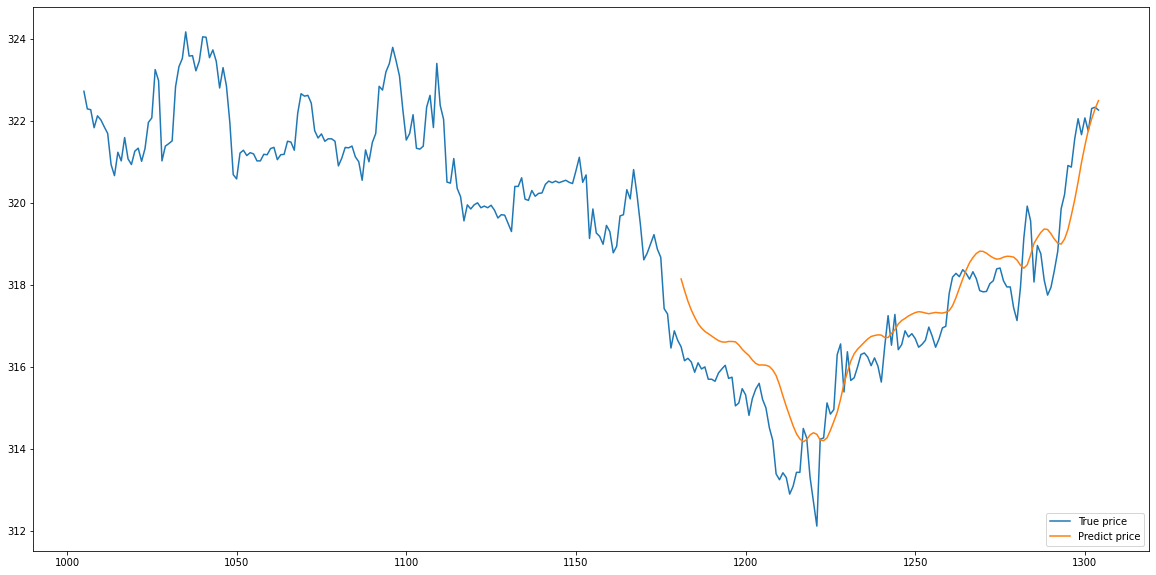

In [21]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [22]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.45048e+02, -3.09400e-01],
       [ 3.45142e+02, -2.58000e-02],
       [ 3.43999e+02, -3.19600e-01],
       ...,
       [ 3.22300e+02,  9.89800e-01],
       [ 3.22330e+02,  7.53300e-01],
       [ 3.22260e+02,  8.44900e-01]])

In [23]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.85438505, 0.65670962],
       [0.85682408, 0.70454392],
       [0.82716658, 0.65498921],
       ...,
       [0.26414115, 0.87584334],
       [0.26491956, 0.83595331],
       [0.26310327, 0.85140332]])

In [24]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1245
1245


In [25]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (996, 60, 2)
Size validate:  (125, 60, 2)
Size test:  (124, 60, 2)


In [26]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC.h5")

Epoch 1/20
32/32 [==============================] - 7s 90ms/step - loss: 0.0226 - val_loss: 0.0021
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0028 - val_loss: 0.0012
Epoch 3/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0014 - val_loss: 6.1406e-04
Epoch 4/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0013 - val_loss: 7.6673e-04
Epoch 5/20
32/32 [==============================] - 2s 48ms/step - loss: 0.0013 - val_loss: 5.7995e-04
Epoch 6/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0012 - val_loss: 5.0663e-04
Epoch 7/20
32/32 [==============================] - 2s 60ms/step - loss: 0.0011 - val_loss: 4.7320e-04
Epoch 8/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0012 - val_loss: 5.4201e-04
Epoch 9/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0011 - val_loss: 5.4055e-04
Epoch 10/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0012 

In [27]:
model_lstm = load_model('./MODEL/LSTM_ROC.h5')

In [28]:
predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]
predictions

array([317.51736, 317.2592 , 317.00616, 316.74765, 316.5134 , 316.2546 ,
       316.0756 , 315.8992 , 315.80762, 315.7794 , 315.83563, 315.89276,
       315.94202, 315.96854, 316.00696, 316.00418, 316.05487, 316.0137 ,
       315.97577, 315.93338, 315.87112, 315.73343, 315.63898, 315.58765,
       315.5782 , 315.54648, 315.45724, 315.29474, 315.07098, 314.7587 ,
       314.4253 , 314.14957, 313.91086, 313.66956, 313.48227, 313.41254,
       313.40912, 313.6181 , 313.8648 , 313.94794, 313.86865, 313.66852,
       313.66556, 313.7441 , 313.95435, 314.19293, 314.43906, 314.85696,
       315.34833, 315.69547, 316.04715, 316.22223, 316.29044, 316.34445,
       316.39627, 316.41443, 316.40057, 316.27454, 316.1709 , 316.14023,
       316.13858, 316.3067 , 316.48386, 316.56165, 316.64157, 316.63263,
       316.60886, 316.55075, 316.47562, 316.51807, 316.53693, 316.58224,
       316.6448 , 316.7085 , 316.79376, 316.85214, 316.86545, 316.8986 ,
       316.958  , 317.0412 , 317.25845, 317.4982 , 

In [29]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date     open     high      low   close    volume  \
1181  2023-08-17 16:15:00  316.880  316.880  316.020  316.49   13741.0   
1182  2023-08-17 16:30:00  316.490  319.065  316.000  316.15   11409.0   
1183  2023-08-17 16:45:00  316.150  316.430  315.950  316.21   12400.0   
1184  2023-08-17 17:00:00  316.166  316.880  296.501  316.12  955828.0   
1185  2023-08-17 17:15:00  316.110  321.635  310.230  315.87   16578.0   
...                   ...      ...      ...      ...     ...       ...   
1300  2023-08-21 14:00:00  321.670  322.170  321.550  322.07  590098.0   
1301  2023-08-21 14:15:00  322.080  322.240  321.540  321.75  336576.0   
1302  2023-08-21 14:30:00  321.770  322.480  321.770  322.30  362083.0   
1303  2023-08-21 14:45:00  322.320  322.770  322.202  322.33  377732.0   
1304  2023-08-21 15:00:00  322.330  322.660  322.060  322.26  495430.0   

         ROC       SMA      RSI  Real Middle Band  Real Lower Band  \
1181 -0.7187  318.6781  33.5012          318.6781       315.835276   
1182 -0.8748  318.5386  32.0495          318.5386       315.714982   
1183 -1.0855  318.3651  32.5921          318.3651       315.639059   
1184 -1.1229  318.1856  32.1863          318.1856       315.484543   
1185 -1.3892  317.9631  31.0556          317.9631       317.254742   
...      ...       ...      ...               ...              ...   
1300  1.5577  319.6248  67.9501          319.6248       317.269963   
1301  1.2015  319.8158  65.4648          319.8158       317.479978   
1302  0.9898  319.9738  67.6082          319.9738       317.654142   
1303  0.7533  320.0943  67.7232          320.0943       317.811700   
1304  0.8449  320.2293  67.1377          320.2293       318.017342   

      Real Upper Band  predictions  
1181       321.520924   317.517365  
1182       321.362218   317.259186  
1183       321.091141   317.006165  
1184       320.886657   316.747650  
1185       318.671458   316.513397  
...               ...          ...  
1300       321.979637   321.278870  
1301       322.151622   321.672394  
1302       322.293458   321.866302  
1303       322.376900   321.928467  
1304       322.441258   321.875061  

[124 rows x 13 columns]

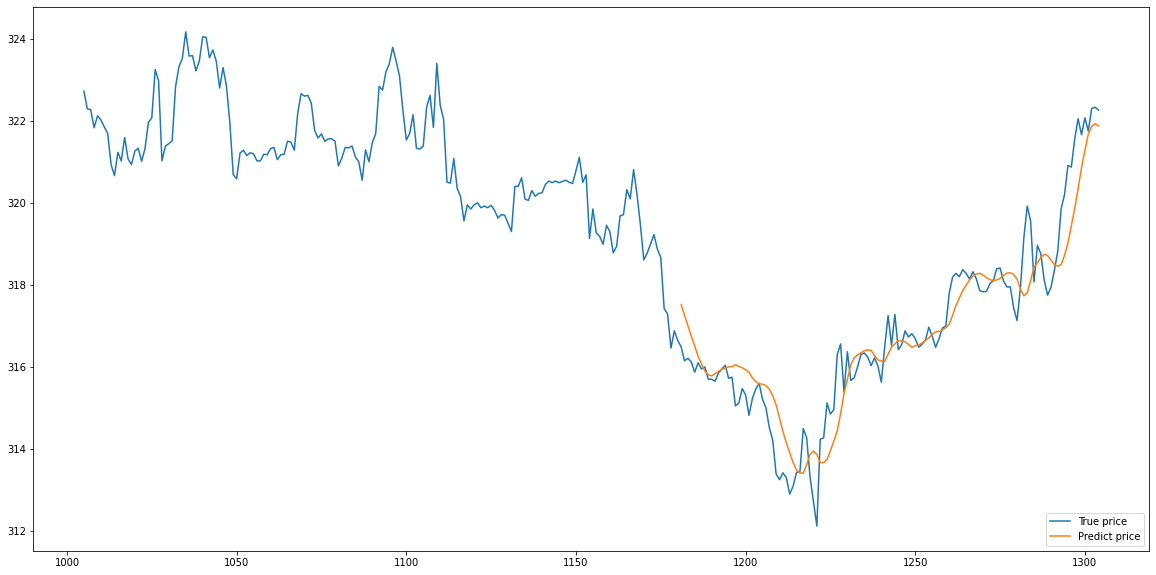

In [30]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/20
32/32 [==============================] - 10s 120ms/step - loss: 0.0196 - val_loss: 0.0016
Epoch 2/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0024 - val_loss: 6.9913e-04
Epoch 3/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0019 - val_loss: 9.5697e-04
Epoch 4/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0018 - val_loss: 5.7838e-04
Epoch 5/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0016 - val_loss: 6.7727e-04
Epoch 6/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0015 - val_loss: 6.5402e-04
Epoch 7/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0015 - val_loss: 5.2019e-04
Epoch 8/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0012 - val_loss: 9.0740e-04
Epoch 9/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0013 - val_loss: 4.8069e-04
Epoch 10/20
32/32 [==============================] - 2s 58ms/step - loss: 0

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


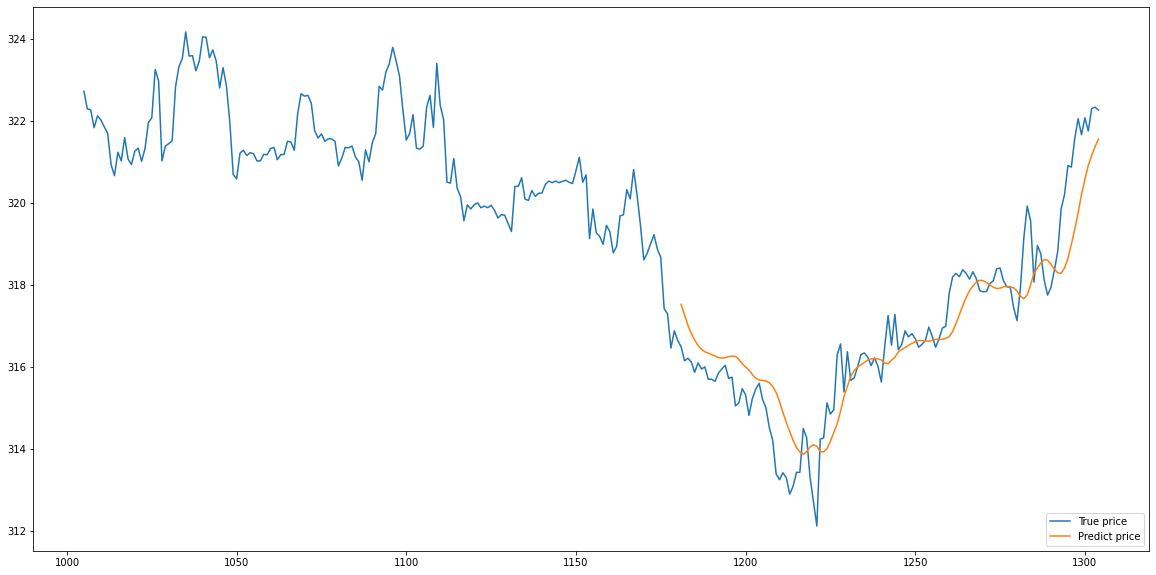

In [31]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/20
32/32 [==============================] - 12s 102ms/step - loss: 0.0189 - val_loss: 5.5948e-04
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0018 - val_loss: 6.7609e-04
Epoch 3/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0011 - val_loss: 5.9239e-04
Epoch 4/20
32/32 [==============================] - 2s 57ms/step - loss: 9.8812e-04 - val_loss: 5.1798e-04
Epoch 5/20
32/32 [==============================] - 2s 57ms/step - loss: 9.9275e-04 - val_loss: 4.9164e-04
Epoch 6/20
32/32 [==============================] - 2s 60ms/step - loss: 9.3854e-04 - val_loss: 4.2115e-04
Epoch 7/20
32/32 [==============================] - 2s 56ms/step - loss: 9.5964e-04 - val_loss: 8.9474e-04
Epoch 8/20
32/32 [==============================] - 2s 57ms/step - loss: 9.5598e-04 - val_loss: 3.7853e-04
Epoch 9/20
32/32 [==============================] - 2s 57ms/step - loss: 8.1346e-04 - val_loss: 3.9345e-04
Epoch 10/20
32/32 [============================

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


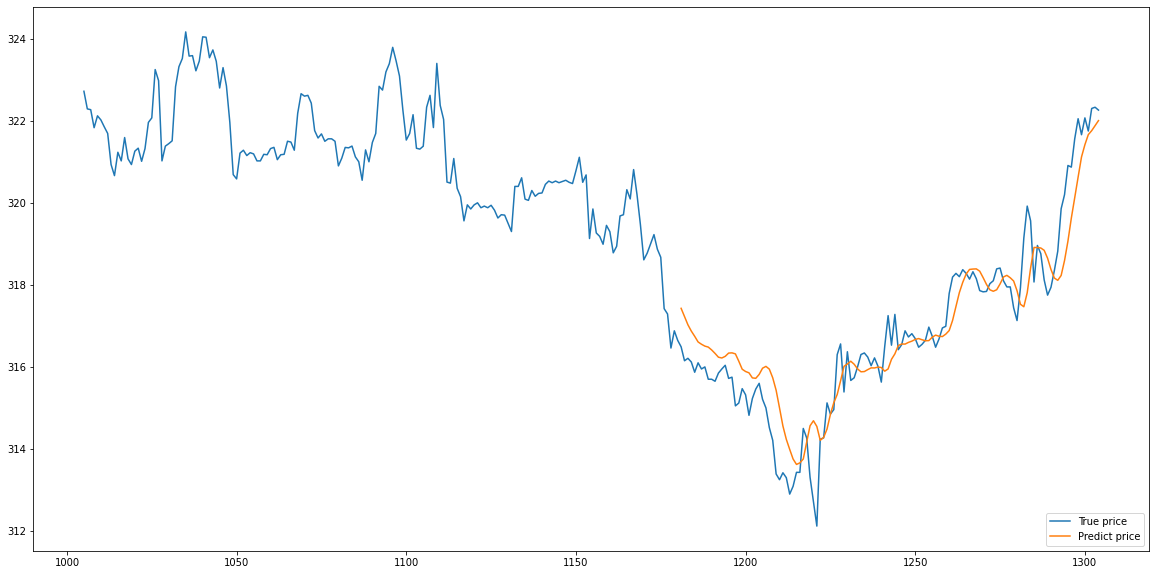

In [32]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 2)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/20
32/32 [==============================] - 10s 101ms/step - loss: 0.0203 - val_loss: 0.0014
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0030 - val_loss: 0.0011
Epoch 3/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0023 - val_loss: 7.8886e-04
Epoch 4/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0021 - val_loss: 7.0489e-04
Epoch 5/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0018 - val_loss: 8.6660e-04
Epoch 6/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0017 - val_loss: 6.4714e-04
Epoch 7/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0016 - val_loss: 8.7341e-04
Epoch 8/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0012 - val_loss: 7.7009e-04
Epoch 9/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 10/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0010 - 

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


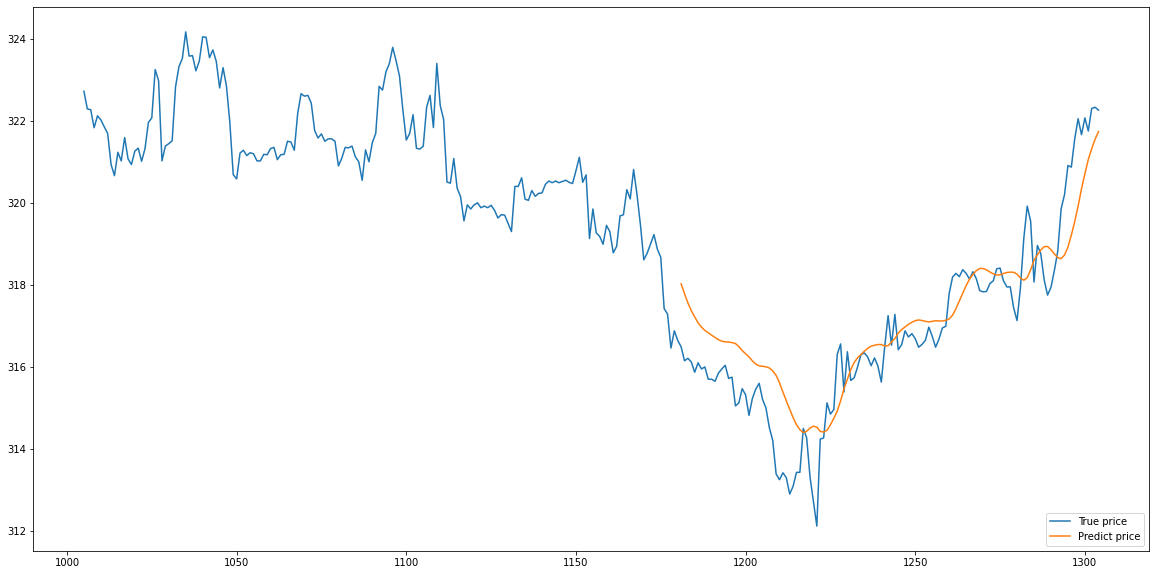

In [33]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/20
32/32 [==============================] - 11s 104ms/step - loss: 0.0252 - val_loss: 0.0020
Epoch 2/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0031 - val_loss: 0.0012
Epoch 3/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0021 - val_loss: 7.5062e-04
Epoch 4/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0017 - val_loss: 5.8947e-04
Epoch 5/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0014 - val_loss: 6.4109e-04
Epoch 6/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0013 - val_loss: 4.9658e-04
Epoch 7/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0013 - val_loss: 5.9373e-04
Epoch 8/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0011 - val_loss: 9.2330e-04
Epoch 9/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0010 - val_loss: 6.1475e-04
Epoch 10/20
32/32 [==============================] - 2s 56ms/step - loss: 9.177

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


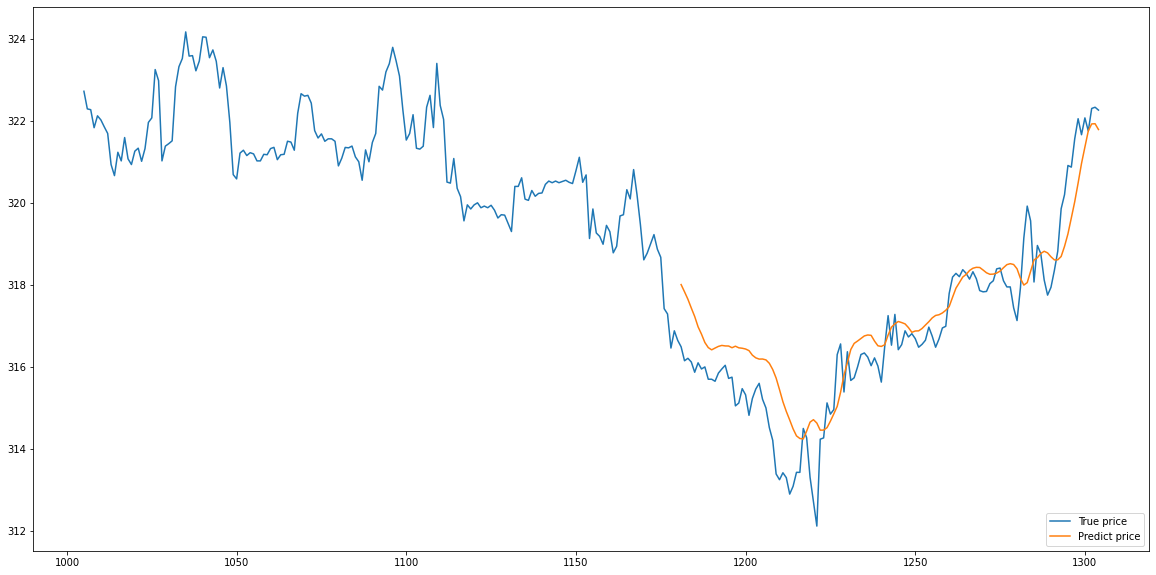

In [34]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/20
32/32 [==============================] - 10s 106ms/step - loss: 0.0182 - val_loss: 8.4325e-04
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0025 - val_loss: 5.9445e-04
Epoch 3/20
32/32 [==============================] - 2s 60ms/step - loss: 0.0017 - val_loss: 5.1747e-04
Epoch 4/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0014 - val_loss: 4.7841e-04
Epoch 5/20
32/32 [==============================] - 2s 61ms/step - loss: 0.0012 - val_loss: 5.8522e-04
Epoch 6/20
32/32 [==============================] - 2s 63ms/step - loss: 0.0011 - val_loss: 5.4736e-04
Epoch 7/20
32/32 [==============================] - 2s 61ms/step - loss: 0.0011 - val_loss: 5.6035e-04
Epoch 8/20
32/32 [==============================] - 2s 61ms/step - loss: 9.7398e-04 - val_loss: 4.7507e-04
Epoch 9/20
32/32 [==============================] - 2s 62ms/step - loss: 9.2010e-04 - val_loss: 4.0044e-04
Epoch 10/20
32/32 [==============================] - 2s 59ms/st

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


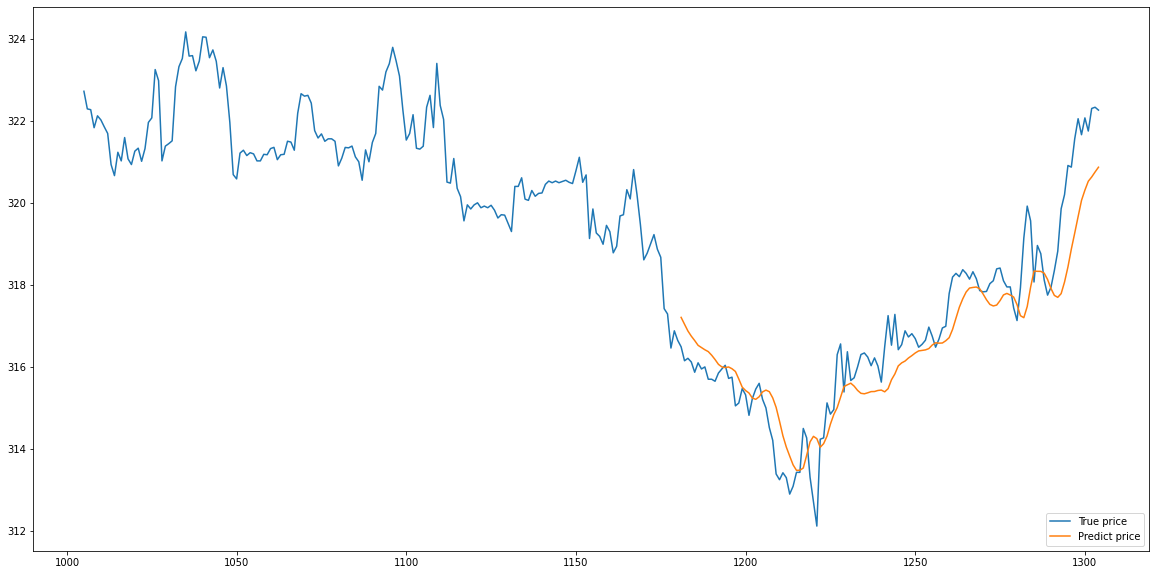

In [35]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/20
32/32 [==============================] - 11s 93ms/step - loss: 0.0175 - val_loss: 9.2959e-04
Epoch 2/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0035 - val_loss: 0.0011
Epoch 3/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0030 - val_loss: 6.8716e-04
Epoch 4/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0025 - val_loss: 6.4121e-04
Epoch 5/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0020 - val_loss: 5.5987e-04
Epoch 6/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0018 - val_loss: 5.9421e-04
Epoch 7/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0013 - val_loss: 5.2803e-04
Epoch 8/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0011 - val_loss: 5.8143e-04
Epoch 9/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0014

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


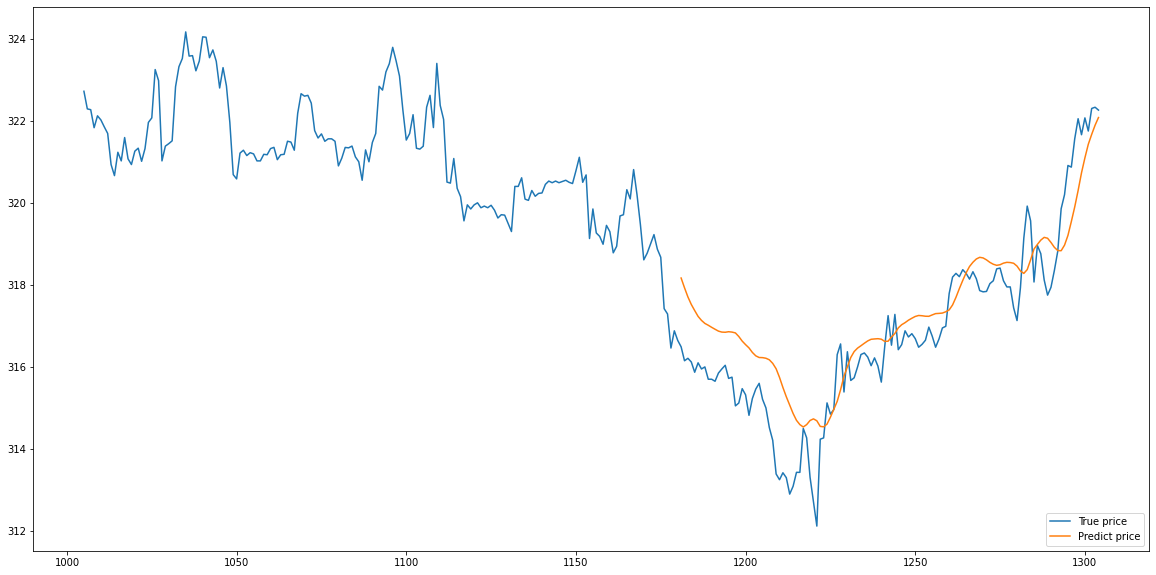

In [36]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/20
32/32 [==============================] - 10s 128ms/step - loss: 0.0293 - val_loss: 7.0270e-04
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 3/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0015 - val_loss: 9.0666e-04
Epoch 4/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0012 - val_loss: 6.6497e-04
Epoch 5/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0011 - val_loss: 5.6676e-04
Epoch 6/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0011 - val_loss: 6.2096e-04
Epoch 7/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0012 - val_loss: 5.1965e-04
Epoch 8/20
32/32 [==============================] - 2s 56ms/step - loss: 9.8349e-04 - val_loss: 6.0449e-04
Epoch 9/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0010 - val_loss: 9.0497e-04
Epoch 10/20
32/32 [==============================] - 2s 56ms/step - los

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


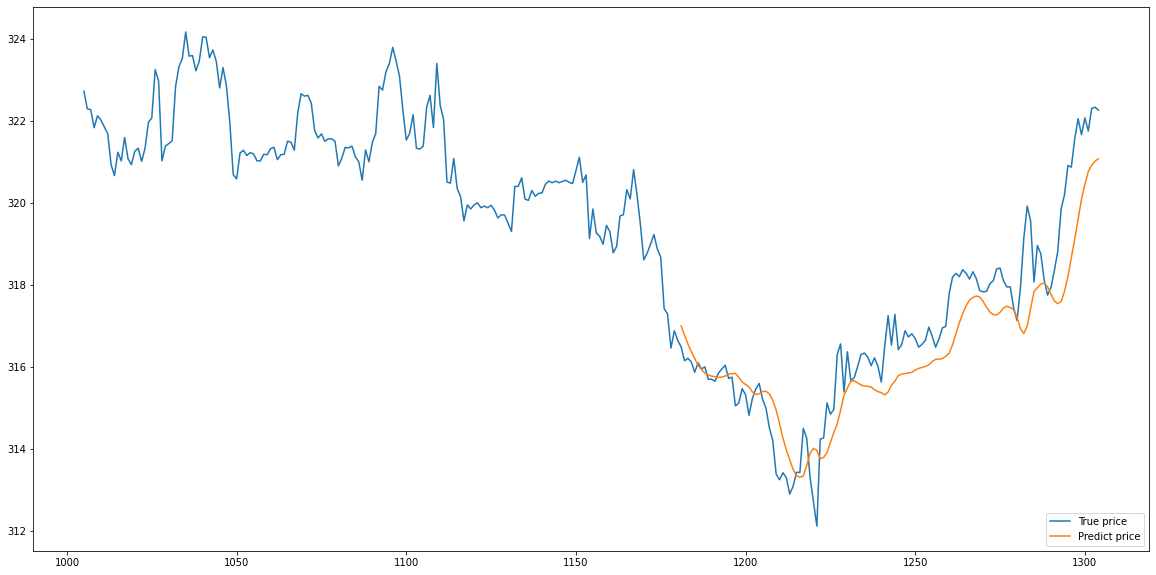

In [37]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/20
32/32 [==============================] - 9s 96ms/step - loss: 0.0250 - val_loss: 6.5267e-04
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0025 - val_loss: 8.6415e-04
Epoch 3/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0018 - val_loss: 8.6243e-04
Epoch 4/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0015 - val_loss: 5.2192e-04
Epoch 5/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0019 - val_loss: 5.9275e-04
Epoch 6/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0012 - val_loss: 4.8436e-04
Epoch 7/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0013 - val_loss: 6.6113e-04
Epoch 8/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 9/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0012 - val_loss: 5.9472e-04
Epoch 10/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


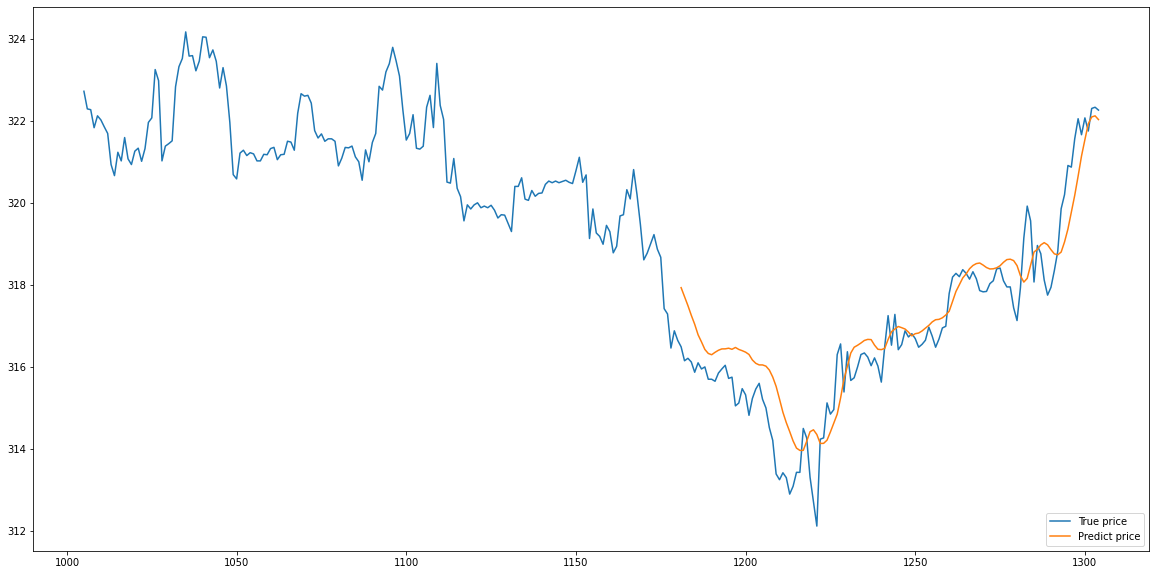

In [38]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/20
32/32 [==============================] - 9s 86ms/step - loss: 0.0127 - val_loss: 5.0882e-04
Epoch 2/20
32/32 [==============================] - 2s 49ms/step - loss: 0.0018 - val_loss: 4.4241e-04
Epoch 3/20
32/32 [==============================] - 2s 49ms/step - loss: 0.0011 - val_loss: 4.5496e-04
Epoch 4/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0011 - val_loss: 4.3916e-04
Epoch 5/20
32/32 [==============================] - 2s 48ms/step - loss: 8.8525e-04 - val_loss: 5.6424e-04
Epoch 6/20
32/32 [==============================] - 2s 51ms/step - loss: 8.7967e-04 - val_loss: 4.3425e-04
Epoch 7/20
32/32 [==============================] - 2s 56ms/step - loss: 8.2462e-04 - val_loss: 4.1590e-04
Epoch 8/20
32/32 [==============================] - 2s 50ms/step - loss: 8.0468e-04 - val_loss: 4.1157e-04
Epoch 9/20
32/32 [==============================] - 2s 50ms/step - loss: 8.0242e-04 - val_loss: 4.0551e-04
Epoch 10/20
32/32 [==============================] - 

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


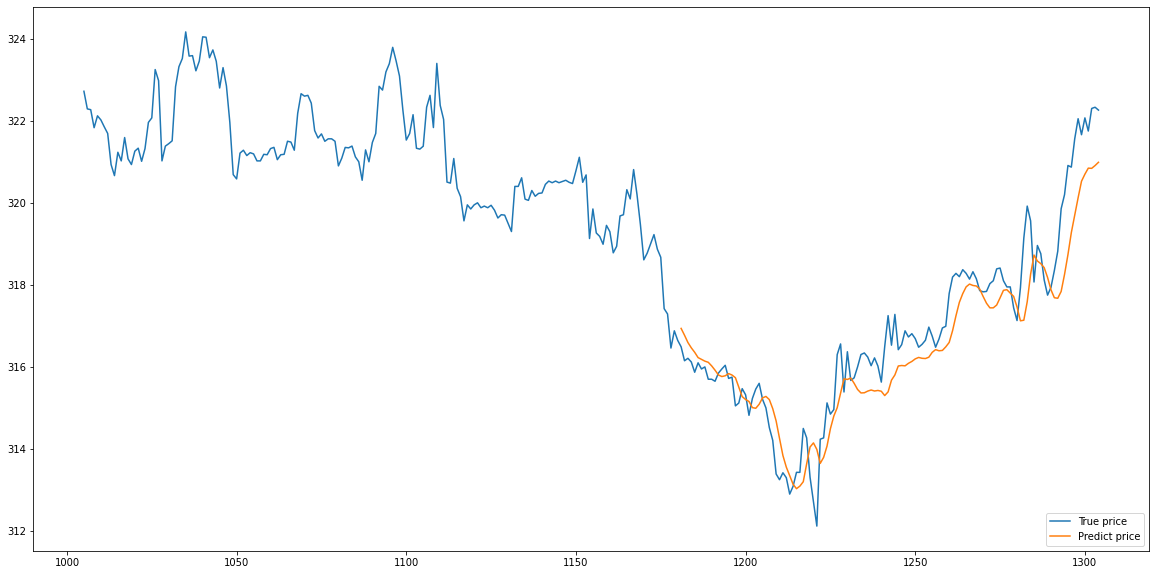

In [39]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/20
32/32 [==============================] - 9s 97ms/step - loss: 0.0298 - val_loss: 7.2890e-04
Epoch 2/20
32/32 [==============================] - 2s 63ms/step - loss: 0.0026 - val_loss: 0.0011
Epoch 3/20
32/32 [==============================] - 2s 68ms/step - loss: 0.0016 - val_loss: 6.4346e-04
Epoch 4/20
32/32 [==============================] - 2s 60ms/step - loss: 0.0015 - val_loss: 4.5801e-04
Epoch 5/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0011 - val_loss: 6.2598e-04
Epoch 6/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0011 - val_loss: 4.4484e-04
Epoch 7/20
32/32 [==============================] - 2s 59ms/step - loss: 9.8555e-04 - val_loss: 4.8263e-04
Epoch 8/20
32/32 [==============================] - 2s 58ms/step - loss: 9.2529e-04 - val_loss: 4.4433e-04
Epoch 9/20
32/32 [==============================] - 2s 62ms/step - loss: 0.0010 - val_loss: 4.4605e-04
Epoch 10/20
32/32 [==============================] - 2s 64ms/step - l

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


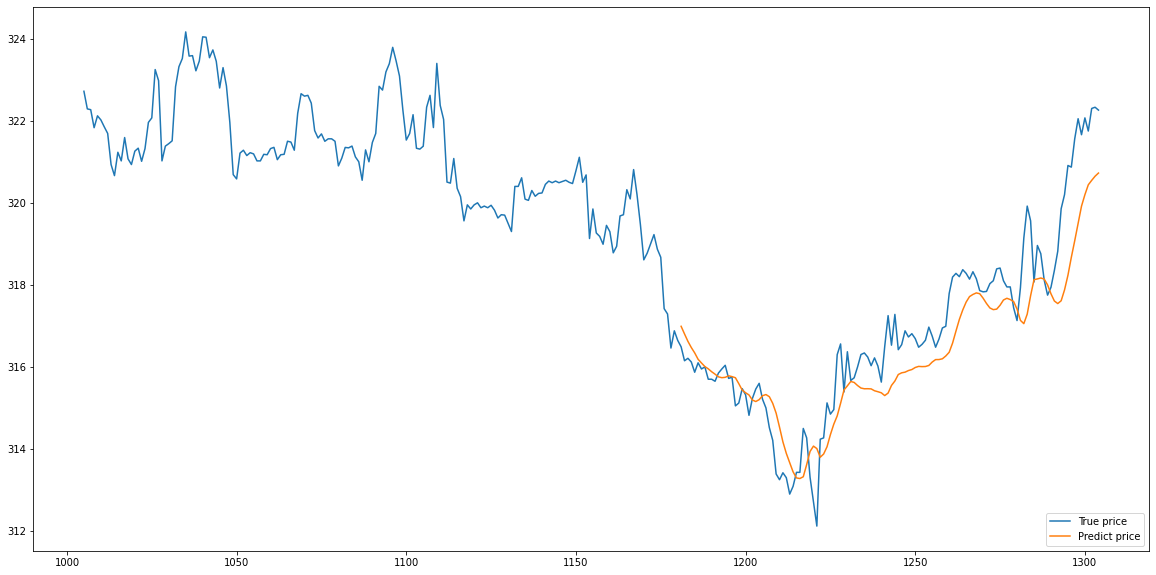

In [40]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/20
32/32 [==============================] - 11s 109ms/step - loss: 0.0120 - val_loss: 0.0014
Epoch 2/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0029 - val_loss: 6.0471e-04
Epoch 3/20
32/32 [==============================] - 2s 58ms/step - loss: 0.0021 - val_loss: 9.7782e-04
Epoch 4/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0016 - val_loss: 7.5263e-04
Epoch 5/20
32/32 [==============================] - 2s 59ms/step - loss: 0.0015 - val_loss: 8.7733e-04
Epoch 6/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0013 - val_loss: 8.9233e-04
Epoch 7/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0012 - val_loss: 8.1982e-04
Epoch 8/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0011 - val_loss: 4.7619e-04
Epoch 9/20
32/32 [==============================] - 2s 54ms/step - loss: 9.7912e-04 - val_loss: 4.9110e-04
Epoch 10/20
32/32 [==============================] - 2s 53ms/step - los

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


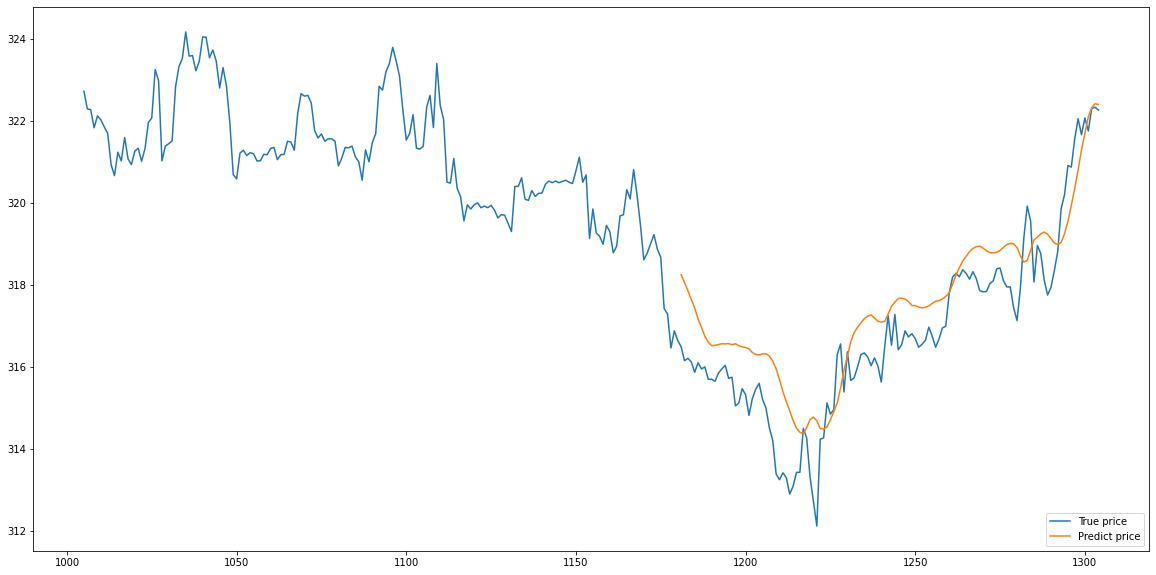

In [41]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/20
32/32 [==============================] - 9s 94ms/step - loss: 0.0216 - val_loss: 5.1928e-04
Epoch 2/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0020 - val_loss: 5.8781e-04
Epoch 3/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0013 - val_loss: 4.6004e-04
Epoch 4/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0013 - val_loss: 5.1856e-04
Epoch 5/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0011 - val_loss: 4.6576e-04
Epoch 6/20
32/32 [==============================] - 2s 50ms/step - loss: 0.0010 - val_loss: 5.1254e-04
Epoch 7/20
32/32 [==============================] - 2s 52ms/step - loss: 9.6293e-04 - val_loss: 4.4762e-04
Epoch 8/20
32/32 [==============================] - 2s 52ms/step - loss: 9.1826e-04 - val_loss: 4.5767e-04
Epoch 9/20
32/32 [==============================] - 2s 52ms/step - loss: 9.4074e-04 - val_loss: 4.2577e-04
Epoch 10/20
32/32 [==============================] - 2s 50ms/

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


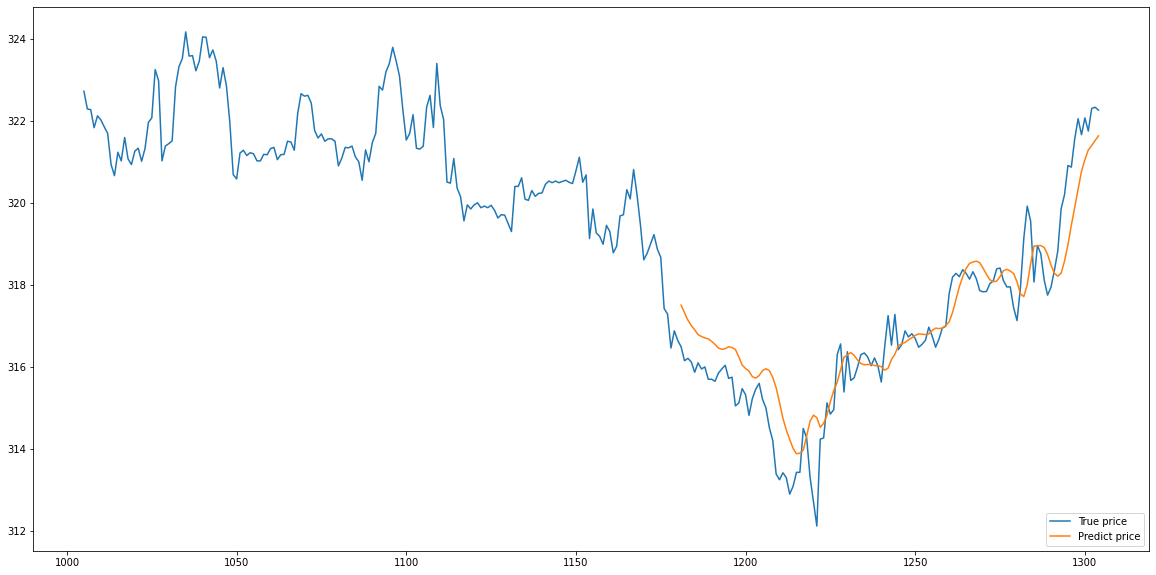

In [42]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/20
32/32 [==============================] - 9s 90ms/step - loss: 0.0372 - val_loss: 6.7851e-04
Epoch 2/20
32/32 [==============================] - 2s 57ms/step - loss: 0.0026 - val_loss: 7.2028e-04
Epoch 3/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0014 - val_loss: 6.3077e-04
Epoch 4/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0011 - val_loss: 7.1763e-04
Epoch 5/20
32/32 [==============================] - 2s 54ms/step - loss: 0.0012 - val_loss: 4.2907e-04
Epoch 6/20
32/32 [==============================] - 2s 51ms/step - loss: 0.0010 - val_loss: 5.1859e-04
Epoch 7/20
32/32 [==============================] - 2s 52ms/step - loss: 9.7054e-04 - val_loss: 4.2865e-04
Epoch 8/20
32/32 [==============================] - 2s 54ms/step - loss: 9.1081e-04 - val_loss: 4.4940e-04
Epoch 9/20
32/32 [==============================] - 2s 53ms/step - loss: 0.0011 - val_loss: 7.5583e-04
Epoch 10/20
32/32 [==============================] - 2s 52ms/step

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


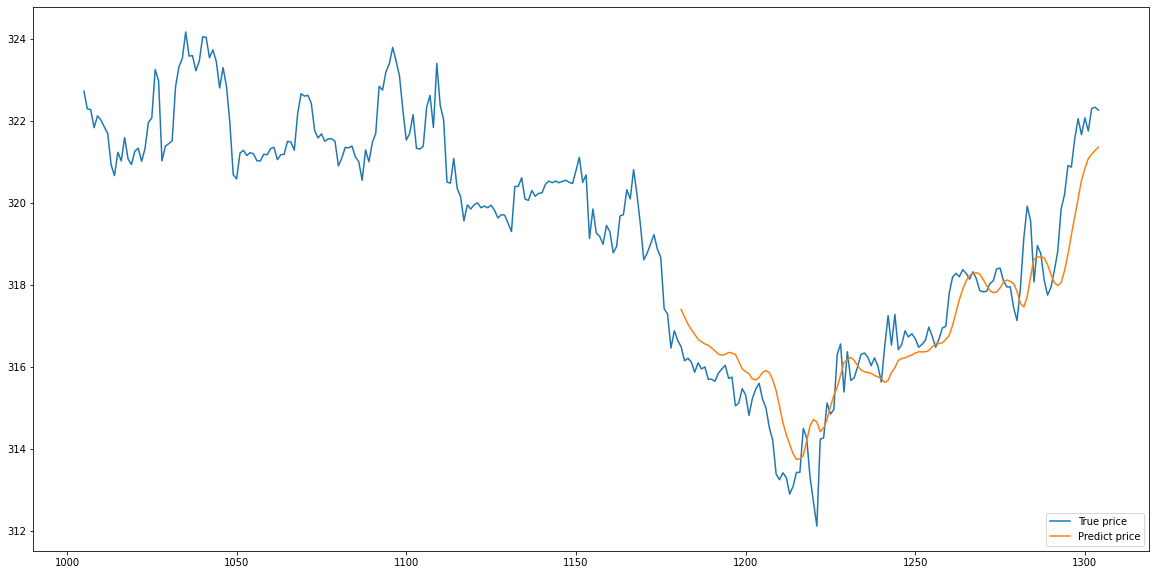

In [43]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/20
32/32 [==============================] - 9s 93ms/step - loss: 0.0260 - val_loss: 0.0015
Epoch 2/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0027 - val_loss: 0.0010
Epoch 3/20
32/32 [==============================] - 2s 56ms/step - loss: 0.0016 - val_loss: 6.1037e-04
Epoch 4/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0013 - val_loss: 6.3218e-04
Epoch 5/20
32/32 [==============================] - 2s 52ms/step - loss: 0.0012 - val_loss: 6.4720e-04
Epoch 6/20
32/32 [==============================] - 2s 55ms/step - loss: 0.0011 - val_loss: 4.3965e-04
Epoch 7/20
32/32 [==============================] - 2s 53ms/step - loss: 9.8402e-04 - val_loss: 6.7070e-04
Epoch 8/20
32/32 [==============================] - 2s 53ms/step - loss: 9.4964e-04 - val_loss: 6.4403e-04
Epoch 9/20
32/32 [==============================] - 2s 53ms/step - loss: 9.7414e-04 - val_loss: 7.6941e-04
Epoch 10/20
32/32 [==============================] - 2s 52ms/step - l

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


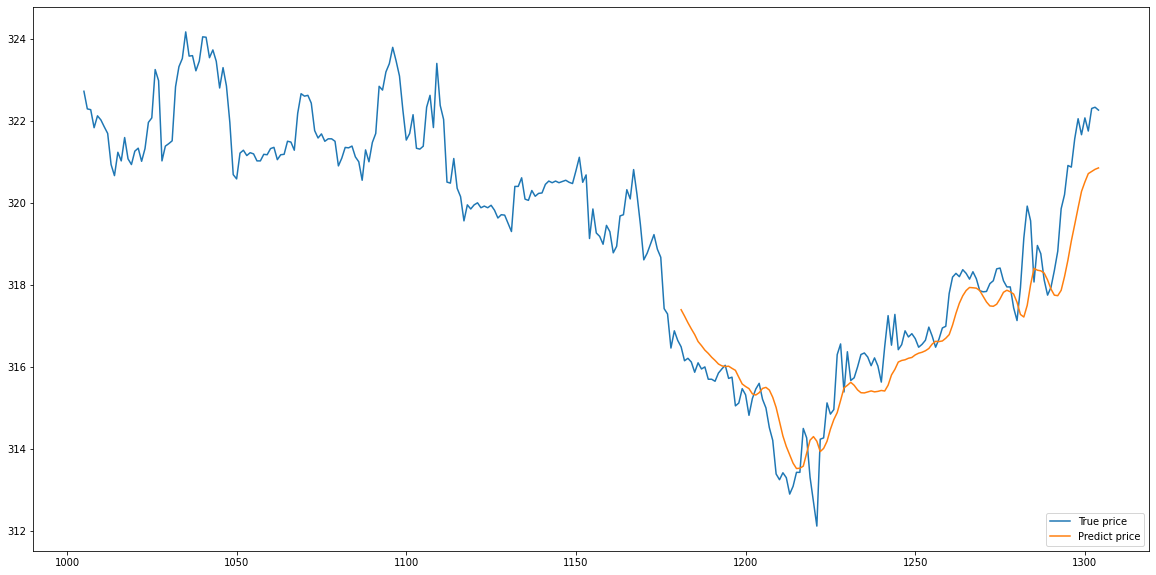

In [44]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], dataset.shape[1])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5")

model_lstm = load_model('./MODEL/LSTM_BBANDS_ROC_RSI_SMA.h5')

predictions = model_lstm.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### e. Predict Future

In [45]:
def lstm_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.h5'
    model = load_model(modelFileName)
    numDataPoint = int(period / 15)
    
    data = data[indicatorArr].values
    data = data[-60:]

    scaler = MinMaxScaler(feature_range=(0,1))
    scaledData = scaler.fit_transform(data)

    modelInput = scaledData.reshape(-1, scaledData.shape[0], scaledData.shape[1])

    predictedScaledValue = model.predict(modelInput)

    predictedValue = scaler.inverse_transform(np.tile(predictedScaledValue, (1, scaledData.shape[1])))[:, 0]
    
    return predictedValue

## 2. RNN

### a. Prepare Input

In [46]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close']].values
dataset

array([[345.048],
       [345.142],
       [343.999],
       ...,
       [322.3  ],
       [322.33 ],
       [322.26 ]])

In [47]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.85438505],
       [0.85682408],
       [0.82716658],
       ...,
       [0.26414115],
       [0.26491956],
       [0.26310327]])

In [48]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1245
1245


In [49]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (996, 60, 1)
Size validate:  (125, 60, 1)
Size test:  (124, 60, 1)


### b. Train Model

In [50]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN.h5")

Epoch 1/25
32/32 [==============================] - 16s 162ms/step - loss: 0.0311 - val_loss: 0.0026
Epoch 2/25
32/32 [==============================] - 3s 109ms/step - loss: 0.0076 - val_loss: 0.0019
Epoch 3/25
32/32 [==============================] - 4s 110ms/step - loss: 0.0059 - val_loss: 0.0013
Epoch 4/25
32/32 [==============================] - 4s 114ms/step - loss: 0.0058 - val_loss: 8.1937e-04
Epoch 5/25
32/32 [==============================] - 4s 110ms/step - loss: 0.0054 - val_loss: 8.8656e-04
Epoch 6/25
32/32 [==============================] - 3s 109ms/step - loss: 0.0069 - val_loss: 0.0011
Epoch 7/25
32/32 [==============================] - 4s 110ms/step - loss: 0.0059 - val_loss: 0.0012
Epoch 8/25
32/32 [==============================] - 3s 109ms/step - loss: 0.0051 - val_loss: 0.0013
Epoch 9/25
32/32 [==============================] - 4s 110ms/step - loss: 0.0046 - val_loss: 0.0015
Epoch 10/25
32/32 [==============================] - 4s 114ms/step - loss: 0.0045 - val_los

### c. Test Model

In [51]:
model_rnn = load_model('./MODEL/RNN.h5')

In [52]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(predictions)

In [53]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date     open     high      low   close    volume  \
1181  2023-08-17 16:15:00  316.880  316.880  316.020  316.49   13741.0   
1182  2023-08-17 16:30:00  316.490  319.065  316.000  316.15   11409.0   
1183  2023-08-17 16:45:00  316.150  316.430  315.950  316.21   12400.0   
1184  2023-08-17 17:00:00  316.166  316.880  296.501  316.12  955828.0   
1185  2023-08-17 17:15:00  316.110  321.635  310.230  315.87   16578.0   
...                   ...      ...      ...      ...     ...       ...   
1300  2023-08-21 14:00:00  321.670  322.170  321.550  322.07  590098.0   
1301  2023-08-21 14:15:00  322.080  322.240  321.540  321.75  336576.0   
1302  2023-08-21 14:30:00  321.770  322.480  321.770  322.30  362083.0   
1303  2023-08-21 14:45:00  322.320  322.770  322.202  322.33  377732.0   
1304  2023-08-21 15:00:00  322.330  322.660  322.060  322.26  495430.0   

         ROC       SMA      RSI  Real Middle Band  Real Lower Band  \
1181 -0.7187  318.6781  33.5012          318.6781       315.835276   
1182 -0.8748  318.5386  32.0495          318.5386       315.714982   
1183 -1.0855  318.3651  32.5921          318.3651       315.639059   
1184 -1.1229  318.1856  32.1863          318.1856       315.484543   
1185 -1.3892  317.9631  31.0556          317.9631       317.254742   
...      ...       ...      ...               ...              ...   
1300  1.5577  319.6248  67.9501          319.6248       317.269963   
1301  1.2015  319.8158  65.4648          319.8158       317.479978   
1302  0.9898  319.9738  67.6082          319.9738       317.654142   
1303  0.7533  320.0943  67.7232          320.0943       317.811700   
1304  0.8449  320.2293  67.1377          320.2293       318.017342   

      Real Upper Band  predictions  
1181       321.520924   318.526337  
1182       321.362218   318.219086  
1183       321.091141   317.906342  
1184       320.886657   317.600616  
1185       318.671458   317.312866  
...               ...          ...  
1300       321.979637   319.381195  
1301       322.151622   319.741302  
1302       322.293458   320.118958  
1303       322.376900   320.493683  
1304       322.441258   320.848297  

[124 rows x 13 columns]

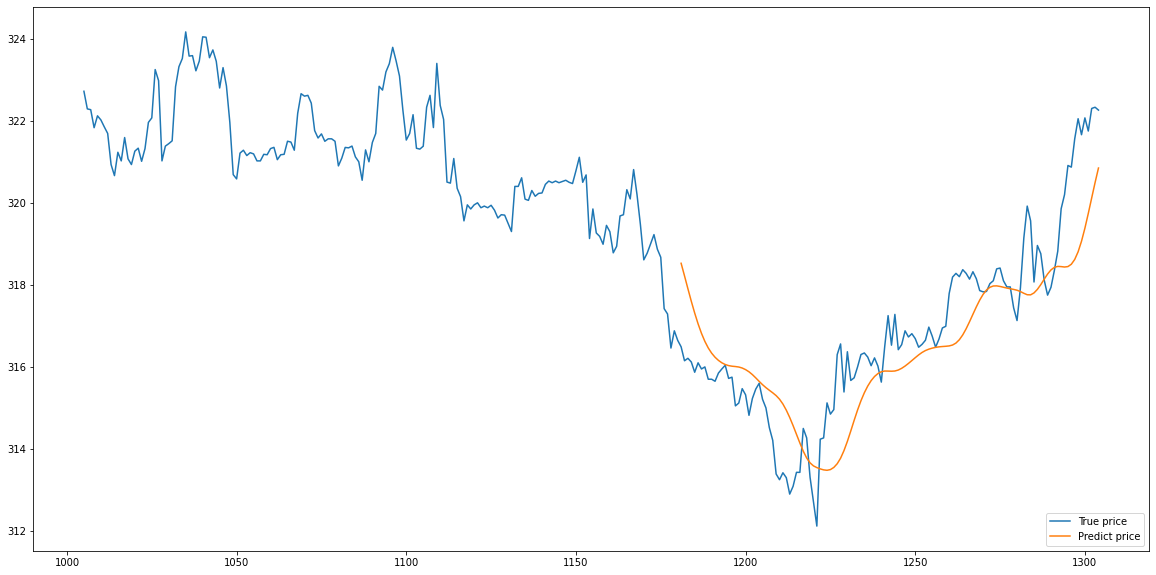

In [54]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [55]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC']].values
dataset

array([[ 3.45048e+02, -3.09400e-01],
       [ 3.45142e+02, -2.58000e-02],
       [ 3.43999e+02, -3.19600e-01],
       ...,
       [ 3.22300e+02,  9.89800e-01],
       [ 3.22330e+02,  7.53300e-01],
       [ 3.22260e+02,  8.44900e-01]])

In [56]:
scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)
dataset

array([[0.85438505, 0.65670962],
       [0.85682408, 0.70454392],
       [0.82716658, 0.65498921],
       ...,
       [0.26414115, 0.87584334],
       [0.26491956, 0.83595331],
       [0.26310327, 0.85140332]])

In [57]:
X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])
print(len(X))
print(len(y))

1245
1245


In [58]:
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (996, 60, 2)
Size validate:  (125, 60, 2)
Size test:  (124, 60, 2)


In [59]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1],2)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC.h5")

Epoch 1/25
32/32 [==============================] - 15s 248ms/step - loss: 0.0282 - val_loss: 0.0011
Epoch 2/25
32/32 [==============================] - 4s 116ms/step - loss: 0.0061 - val_loss: 0.0014
Epoch 3/25
32/32 [==============================] - 4s 120ms/step - loss: 0.0055 - val_loss: 8.1400e-04
Epoch 4/25
32/32 [==============================] - 4s 122ms/step - loss: 0.0051 - val_loss: 7.4893e-04
Epoch 5/25
32/32 [==============================] - 4s 118ms/step - loss: 0.0052 - val_loss: 0.0011
Epoch 6/25
32/32 [==============================] - 4s 116ms/step - loss: 0.0050 - val_loss: 0.0015
Epoch 7/25
32/32 [==============================] - 4s 117ms/step - loss: 0.0039 - val_loss: 8.0035e-04
Epoch 8/25
32/32 [==============================] - 4s 117ms/step - loss: 0.0044 - val_loss: 6.9519e-04
Epoch 9/25
32/32 [==============================] - 4s 121ms/step - loss: 0.0042 - val_loss: 6.9777e-04
Epoch 10/25
32/32 [==============================] - 4s 118ms/step - loss: 0.00

In [60]:
model_rnn = load_model('./MODEL/RNN_ROC.h5')

In [61]:
predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, 2)))[:, 0]

In [62]:
prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


date     open     high      low   close    volume  \
1181  2023-08-17 16:15:00  316.880  316.880  316.020  316.49   13741.0   
1182  2023-08-17 16:30:00  316.490  319.065  316.000  316.15   11409.0   
1183  2023-08-17 16:45:00  316.150  316.430  315.950  316.21   12400.0   
1184  2023-08-17 17:00:00  316.166  316.880  296.501  316.12  955828.0   
1185  2023-08-17 17:15:00  316.110  321.635  310.230  315.87   16578.0   
...                   ...      ...      ...      ...     ...       ...   
1300  2023-08-21 14:00:00  321.670  322.170  321.550  322.07  590098.0   
1301  2023-08-21 14:15:00  322.080  322.240  321.540  321.75  336576.0   
1302  2023-08-21 14:30:00  321.770  322.480  321.770  322.30  362083.0   
1303  2023-08-21 14:45:00  322.320  322.770  322.202  322.33  377732.0   
1304  2023-08-21 15:00:00  322.330  322.660  322.060  322.26  495430.0   

         ROC       SMA      RSI  Real Middle Band  Real Lower Band  \
1181 -0.7187  318.6781  33.5012          318.6781       315.835276   
1182 -0.8748  318.5386  32.0495          318.5386       315.714982   
1183 -1.0855  318.3651  32.5921          318.3651       315.639059   
1184 -1.1229  318.1856  32.1863          318.1856       315.484543   
1185 -1.3892  317.9631  31.0556          317.9631       317.254742   
...      ...       ...      ...               ...              ...   
1300  1.5577  319.6248  67.9501          319.6248       317.269963   
1301  1.2015  319.8158  65.4648          319.8158       317.479978   
1302  0.9898  319.9738  67.6082          319.9738       317.654142   
1303  0.7533  320.0943  67.7232          320.0943       317.811700   
1304  0.8449  320.2293  67.1377          320.2293       318.017342   

      Real Upper Band  predictions  
1181       321.520924   318.978638  
1182       321.362218   318.723328  
1183       321.091141   318.459930  
1184       320.886657   318.195129  
1185       318.671458   317.935181  
...               ...          ...  
1300       321.979637   319.955078  
1301       322.151622   320.336060  
1302       322.293458   320.712433  
1303       322.376900   321.052795  
1304       322.441258   321.332764  

[124 rows x 13 columns]

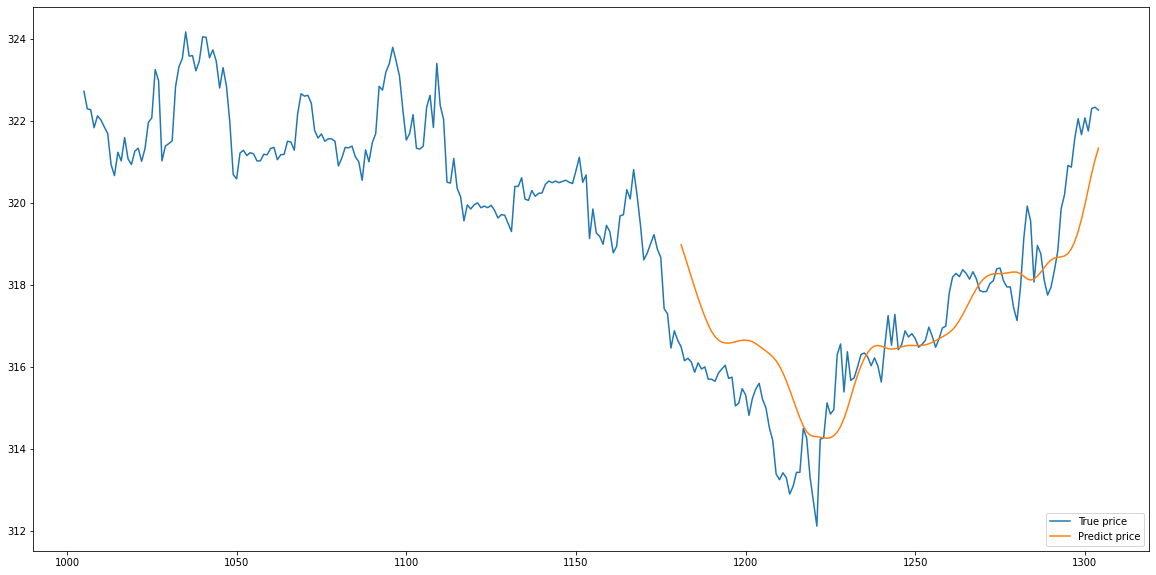

In [63]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

Epoch 1/25
32/32 [==============================] - 20s 195ms/step - loss: 0.0263 - val_loss: 0.0023
Epoch 2/25
32/32 [==============================] - 4s 117ms/step - loss: 0.0078 - val_loss: 9.5442e-04
Epoch 3/25
32/32 [==============================] - 4s 112ms/step - loss: 0.0064 - val_loss: 7.6750e-04
Epoch 4/25
32/32 [==============================] - 4s 111ms/step - loss: 0.0062 - val_loss: 0.0013
Epoch 5/25
32/32 [==============================] - 4s 113ms/step - loss: 0.0051 - val_loss: 0.0011
Epoch 6/25
32/32 [==============================] - 4s 120ms/step - loss: 0.0057 - val_loss: 7.8886e-04
Epoch 7/25
32/32 [==============================] - 4s 113ms/step - loss: 0.0051 - val_loss: 7.3766e-04
Epoch 8/25
32/32 [==============================] - 4s 111ms/step - loss: 0.0046 - val_loss: 7.1433e-04
Epoch 9/25
32/32 [==============================] - 4s 112ms/step - loss: 0.0055 - val_loss: 0.0029
Epoch 10/25
32/32 [==============================] - 4s 121ms/step - loss: 0.00

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


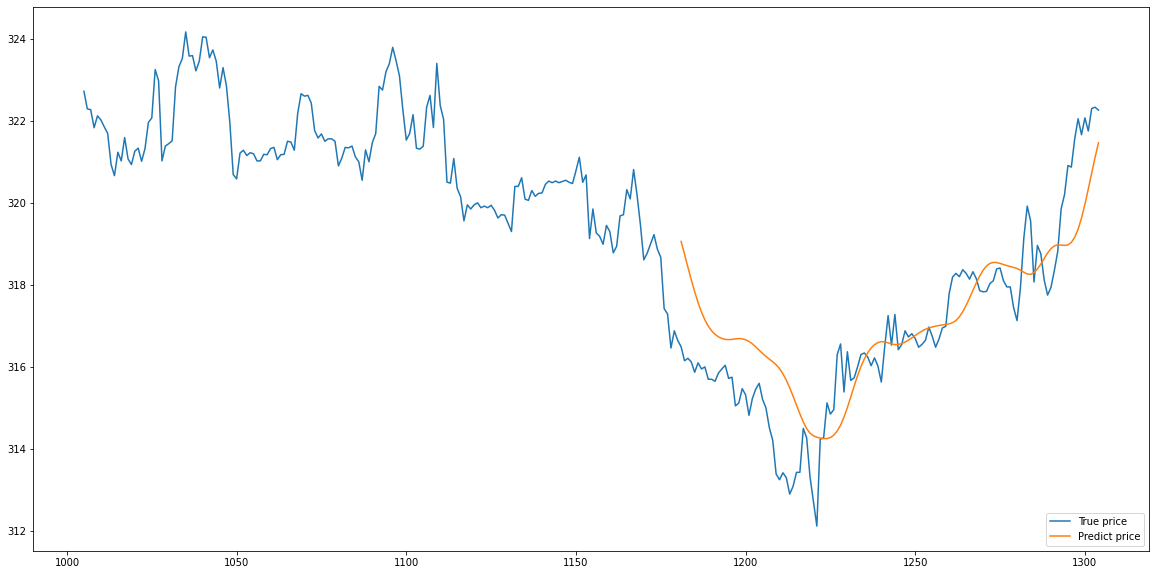

In [64]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_SMA.h5")

model_rnn = load_model('./MODEL/RNN_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

Epoch 1/25
32/32 [==============================] - 19s 179ms/step - loss: 0.0387 - val_loss: 0.0088
Epoch 2/25
32/32 [==============================] - 3s 95ms/step - loss: 0.0068 - val_loss: 8.0738e-04
Epoch 3/25
32/32 [==============================] - 3s 96ms/step - loss: 0.0053 - val_loss: 0.0010
Epoch 4/25
32/32 [==============================] - 3s 99ms/step - loss: 0.0046 - val_loss: 0.0012
Epoch 5/25
32/32 [==============================] - 3s 94ms/step - loss: 0.0045 - val_loss: 0.0014
Epoch 6/25
32/32 [==============================] - 3s 87ms/step - loss: 0.0047 - val_loss: 0.0038
Epoch 7/25
32/32 [==============================] - 3s 89ms/step - loss: 0.0048 - val_loss: 6.8786e-04
Epoch 8/25
32/32 [==============================] - 3s 95ms/step - loss: 0.0040 - val_loss: 8.1609e-04
Epoch 9/25
32/32 [==============================] - 3s 95ms/step - loss: 0.0039 - val_loss: 8.9839e-04
Epoch 10/25
32/32 [==============================] - 3s 93ms/step - loss: 0.0035 - val_loss

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


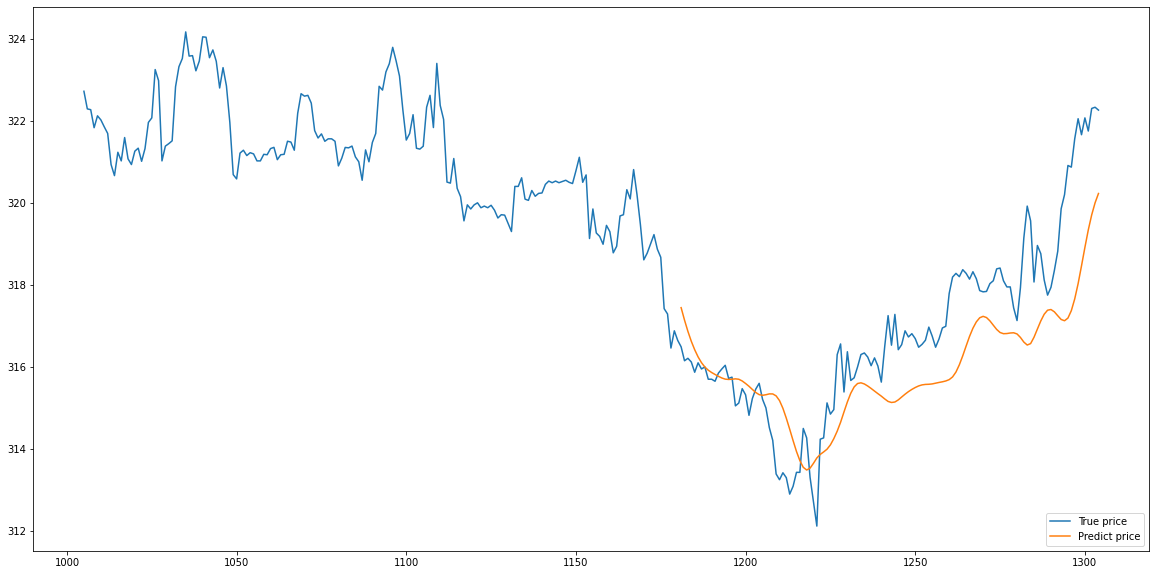

In [65]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI.h5")

model_rnn = load_model('./MODEL/RNN_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

Epoch 1/25
32/32 [==============================] - 13s 123ms/step - loss: 0.0337 - val_loss: 0.0041
Epoch 2/25
32/32 [==============================] - 3s 79ms/step - loss: 0.0070 - val_loss: 0.0012
Epoch 3/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0060 - val_loss: 0.0022
Epoch 4/25
32/32 [==============================] - 3s 79ms/step - loss: 0.0054 - val_loss: 0.0017
Epoch 5/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0054 - val_loss: 0.0014
Epoch 6/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0050 - val_loss: 0.0024
Epoch 7/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0047 - val_loss: 7.3449e-04
Epoch 8/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0047 - val_loss: 7.1428e-04
Epoch 9/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0041 - val_loss: 7.1867e-04
Epoch 10/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0040 - val_loss: 0.

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


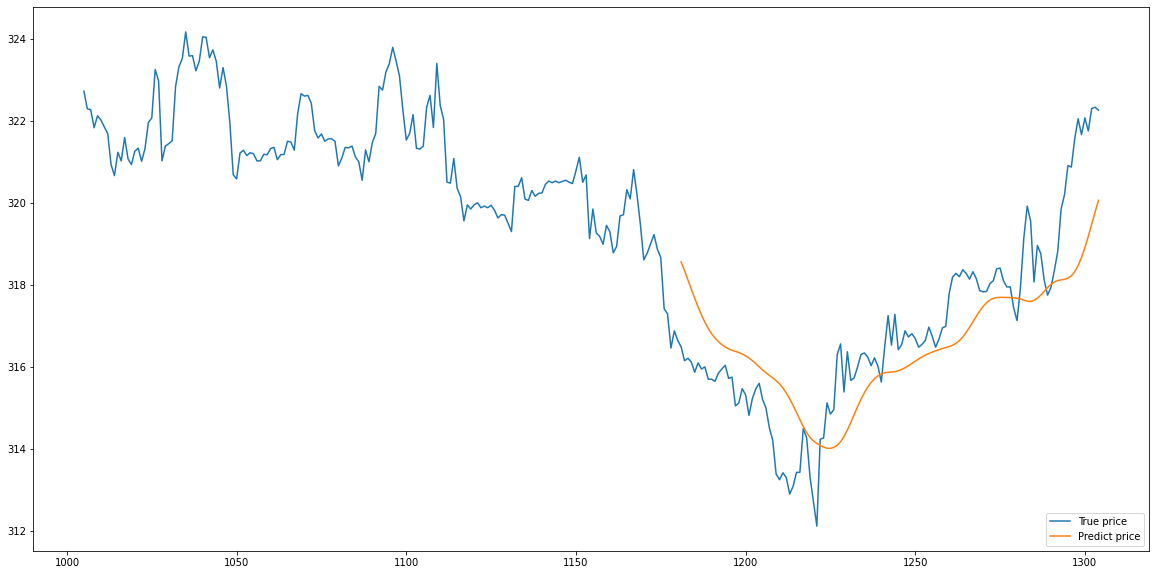

In [66]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

Epoch 1/25
32/32 [==============================] - 10s 117ms/step - loss: 0.0342 - val_loss: 6.6084e-04
Epoch 2/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0071 - val_loss: 0.0014
Epoch 3/25
32/32 [==============================] - 2s 75ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 4/25
32/32 [==============================] - 2s 77ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 5/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0055 - val_loss: 0.0014
Epoch 6/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0046 - val_loss: 0.0011
Epoch 7/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0043 - val_loss: 0.0013
Epoch 8/25
32/32 [==============================] - 2s 74ms/step - loss: 0.0040 - val_loss: 0.0027
Epoch 9/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0043 - val_loss: 0.0023
Epoch 10/25
32/32 [==============================] - 2s 73ms/step - loss: 0.0039 - val_loss: 0.0010
Epo

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


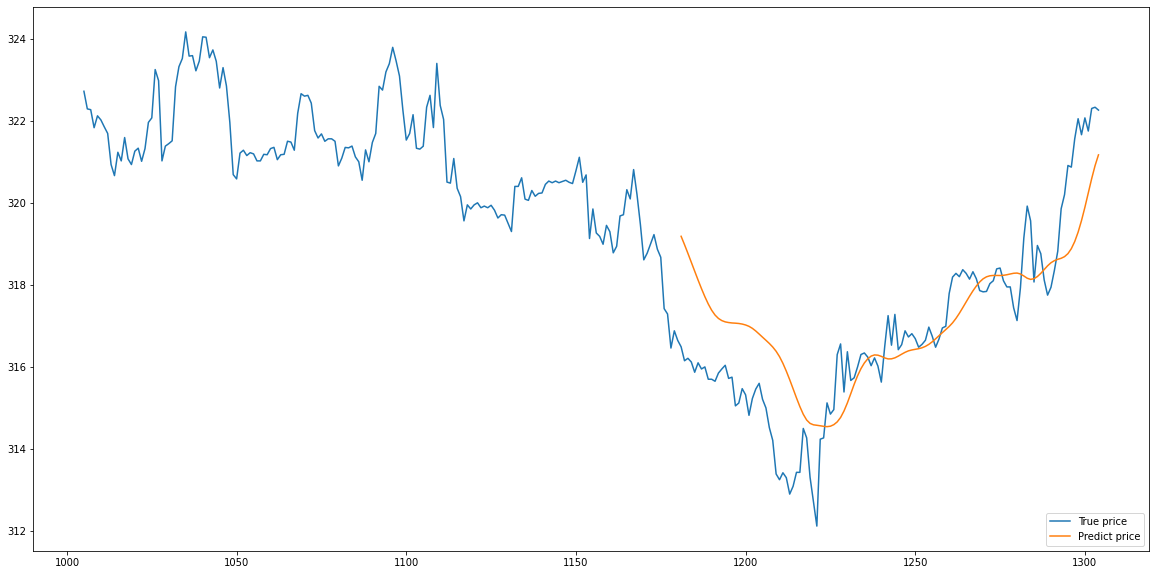

In [67]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

Epoch 1/25
32/32 [==============================] - 10s 118ms/step - loss: 0.0309 - val_loss: 0.0076
Epoch 2/25
32/32 [==============================] - 2s 73ms/step - loss: 0.0071 - val_loss: 0.0020
Epoch 3/25
32/32 [==============================] - 2s 71ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 4/25
32/32 [==============================] - 2s 70ms/step - loss: 0.0051 - val_loss: 0.0028
Epoch 5/25
32/32 [==============================] - 2s 72ms/step - loss: 0.0053 - val_loss: 0.0017
Epoch 6/25
32/32 [==============================] - 2s 73ms/step - loss: 0.0043 - val_loss: 0.0020
Epoch 7/25
32/32 [==============================] - 2s 72ms/step - loss: 0.0050 - val_loss: 7.0428e-04
Epoch 8/25
32/32 [==============================] - 2s 77ms/step - loss: 0.0045 - val_loss: 6.7518e-04
Epoch 9/25
32/32 [==============================] - 2s 77ms/step - loss: 0.0044 - val_loss: 6.7985e-04
Epoch 10/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0044 - val_loss: 0.

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


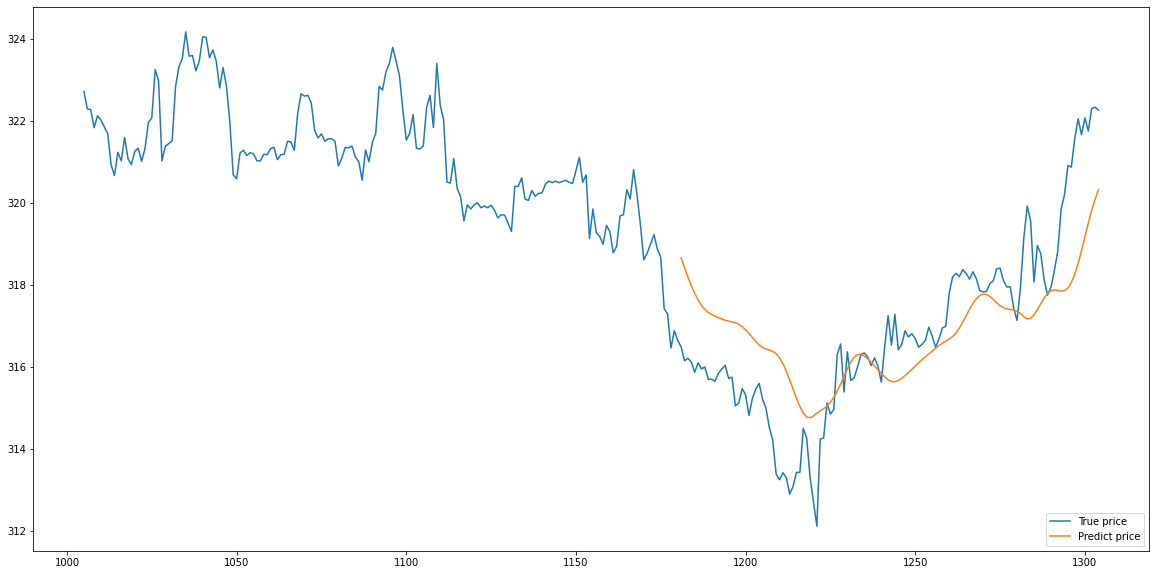

In [68]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

Epoch 1/25
32/32 [==============================] - 10s 121ms/step - loss: 0.0306 - val_loss: 0.0038
Epoch 2/25
32/32 [==============================] - 3s 79ms/step - loss: 0.0077 - val_loss: 7.8446e-04
Epoch 3/25
32/32 [==============================] - 3s 79ms/step - loss: 0.0069 - val_loss: 9.3252e-04
Epoch 4/25
32/32 [==============================] - 3s 80ms/step - loss: 0.0058 - val_loss: 8.0996e-04
Epoch 5/25
32/32 [==============================] - 3s 79ms/step - loss: 0.0056 - val_loss: 7.9886e-04
Epoch 6/25
32/32 [==============================] - 2s 78ms/step - loss: 0.0050 - val_loss: 7.8555e-04
Epoch 7/25
32/32 [==============================] - 2s 78ms/step - loss: 0.0048 - val_loss: 7.0690e-04
Epoch 8/25
32/32 [==============================] - 3s 78ms/step - loss: 0.0054 - val_loss: 7.0931e-04
Epoch 9/25
32/32 [==============================] - 3s 79ms/step - loss: 0.0063 - val_loss: 8.1447e-04
Epoch 10/25
32/32 [==============================] - 3s 81ms/step - loss: 0

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


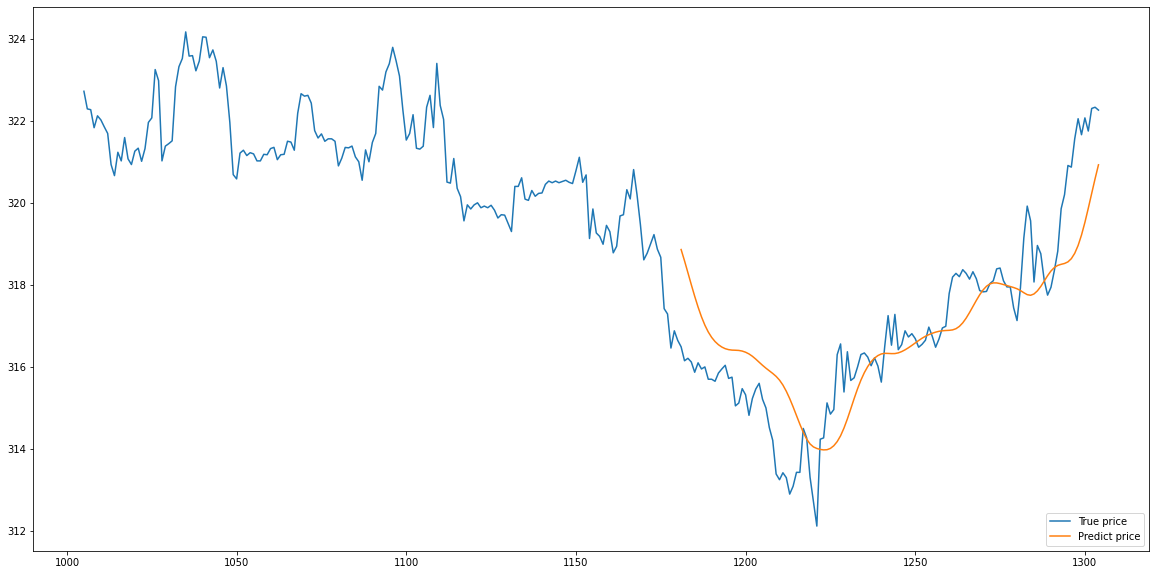

In [69]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

Epoch 1/25
32/32 [==============================] - 9s 116ms/step - loss: 0.0297 - val_loss: 7.7676e-04
Epoch 2/25
32/32 [==============================] - 2s 72ms/step - loss: 0.0058 - val_loss: 0.0011
Epoch 3/25
32/32 [==============================] - 2s 72ms/step - loss: 0.0055 - val_loss: 0.0012
Epoch 4/25
32/32 [==============================] - 2s 72ms/step - loss: 0.0052 - val_loss: 8.3763e-04
Epoch 5/25
32/32 [==============================] - 2s 74ms/step - loss: 0.0046 - val_loss: 9.9335e-04
Epoch 6/25
32/32 [==============================] - 2s 73ms/step - loss: 0.0057 - val_loss: 0.0010
Epoch 7/25
32/32 [==============================] - 2s 73ms/step - loss: 0.0066 - val_loss: 7.7687e-04
Epoch 8/25
32/32 [==============================] - 2s 73ms/step - loss: 0.0040 - val_loss: 8.7100e-04
Epoch 9/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0040 - val_loss: 0.0013
Epoch 10/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0036 - val_l

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


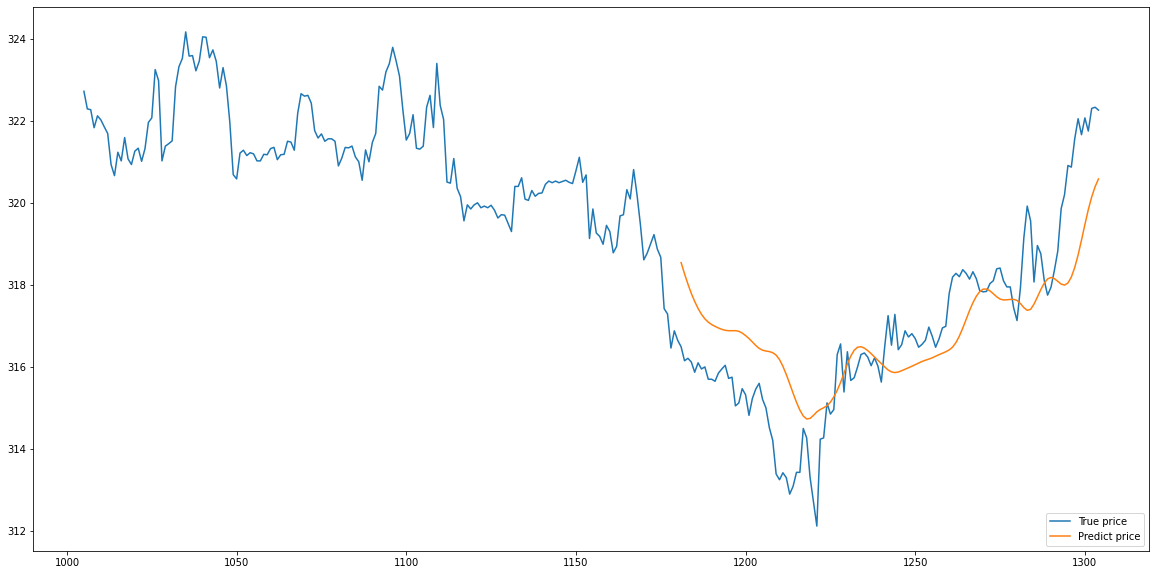

In [70]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

Epoch 1/25
32/32 [==============================] - 10s 119ms/step - loss: 0.0323 - val_loss: 0.0015
Epoch 2/25
32/32 [==============================] - 2s 75ms/step - loss: 0.0078 - val_loss: 8.4971e-04
Epoch 3/25
32/32 [==============================] - 2s 76ms/step - loss: 0.0073 - val_loss: 7.2115e-04
Epoch 4/25
32/32 [==============================] - 2s 74ms/step - loss: 0.0058 - val_loss: 0.0012
Epoch 5/25
32/32 [==============================] - 2s 70ms/step - loss: 0.0053 - val_loss: 9.6958e-04
Epoch 6/25
32/32 [==============================] - 2s 70ms/step - loss: 0.0051 - val_loss: 8.1430e-04
Epoch 7/25
32/32 [==============================] - 2s 71ms/step - loss: 0.0049 - val_loss: 0.0011
Epoch 8/25
32/32 [==============================] - 2s 70ms/step - loss: 0.0046 - val_loss: 0.0018
Epoch 9/25
32/32 [==============================] - 2s 71ms/step - loss: 0.0045 - val_loss: 0.0025
Epoch 10/25
32/32 [==============================] - 2s 71ms/step - loss: 0.0044 - val_loss

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


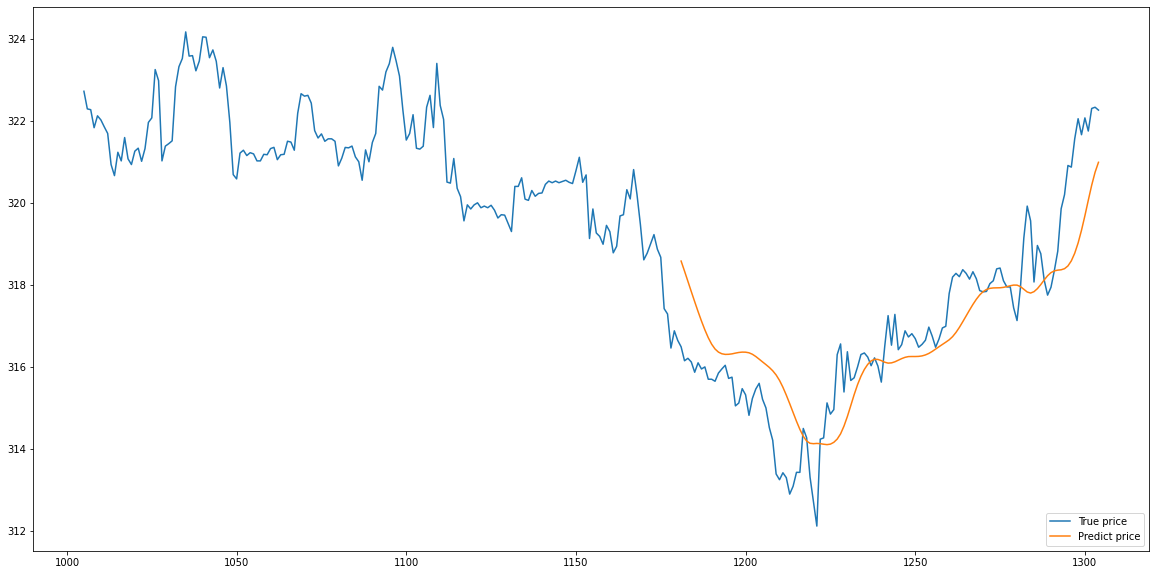

In [71]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

Epoch 1/25
32/32 [==============================] - 8s 101ms/step - loss: 0.0249 - val_loss: 8.8341e-04
Epoch 2/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0056 - val_loss: 7.1727e-04
Epoch 3/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0046 - val_loss: 9.2654e-04
Epoch 4/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0052 - val_loss: 8.0296e-04
Epoch 5/25
32/32 [==============================] - 2s 63ms/step - loss: 0.0042 - val_loss: 8.5485e-04
Epoch 6/25
32/32 [==============================] - 2s 61ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 7/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0047 - val_loss: 0.0013
Epoch 8/25
32/32 [==============================] - 2s 61ms/step - loss: 0.0043 - val_loss: 0.0010
Epoch 9/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0041 - val_loss: 6.9240e-04
Epoch 10/25
32/32 [==============================] - 2s 61ms/step - loss: 0.0038 - v

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


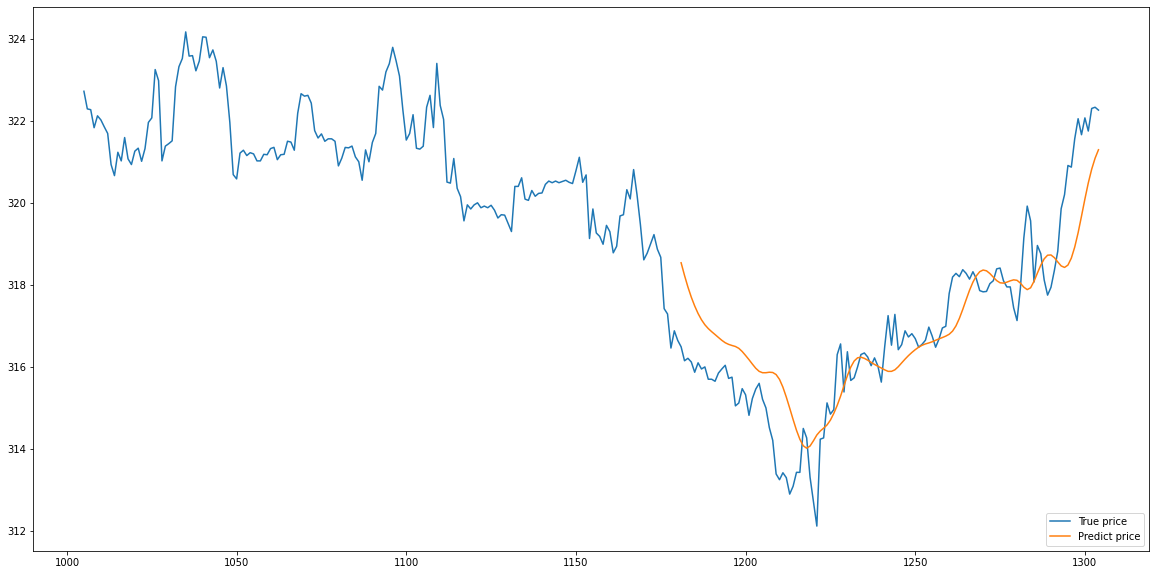

In [72]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

Epoch 1/25
32/32 [==============================] - 8s 99ms/step - loss: 0.0269 - val_loss: 0.0012
Epoch 2/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0064 - val_loss: 6.9529e-04
Epoch 3/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0055 - val_loss: 0.0011
Epoch 4/25
32/32 [==============================] - 2s 63ms/step - loss: 0.0056 - val_loss: 6.7164e-04
Epoch 5/25
32/32 [==============================] - 2s 63ms/step - loss: 0.0045 - val_loss: 6.7759e-04
Epoch 6/25
32/32 [==============================] - 2s 63ms/step - loss: 0.0041 - val_loss: 7.2126e-04
Epoch 7/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0037 - val_loss: 8.9325e-04
Epoch 8/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0038 - val_loss: 9.1585e-04
Epoch 9/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0037 - val_loss: 8.7081e-04
Epoch 10/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0038 

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


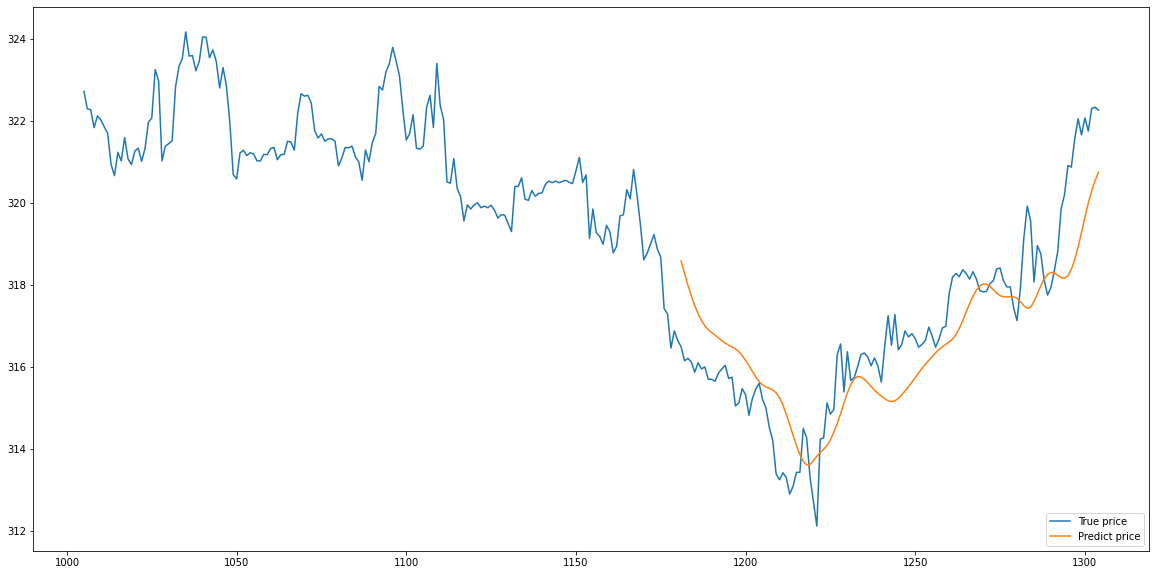

In [73]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

Epoch 1/25
32/32 [==============================] - 9s 104ms/step - loss: 0.0397 - val_loss: 0.0010
Epoch 2/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0084 - val_loss: 0.0025
Epoch 3/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0072 - val_loss: 0.0024
Epoch 4/25
32/32 [==============================] - 2s 63ms/step - loss: 0.0062 - val_loss: 7.4781e-04
Epoch 5/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0063 - val_loss: 0.0012
Epoch 6/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0051 - val_loss: 6.8532e-04
Epoch 7/25
32/32 [==============================] - 2s 62ms/step - loss: 0.0053 - val_loss: 7.7717e-04
Epoch 8/25
32/32 [==============================] - 3s 81ms/step - loss: 0.0054 - val_loss: 0.0011
Epoch 9/25
32/32 [==============================] - 3s 84ms/step - loss: 0.0045 - val_loss: 6.8461e-04
Epoch 10/25
32/32 [==============================] - 3s 90ms/step - loss: 0.0045 - val_loss:

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


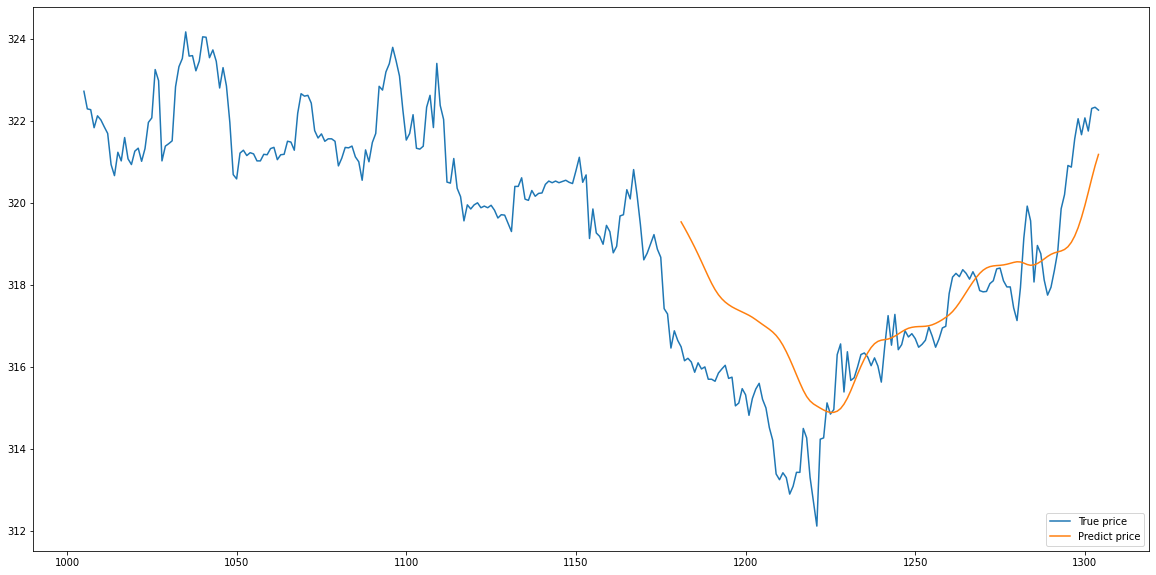

In [74]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

Epoch 1/25
32/32 [==============================] - 20s 192ms/step - loss: 0.0287 - val_loss: 0.0032
Epoch 2/25
32/32 [==============================] - 3s 98ms/step - loss: 0.0067 - val_loss: 0.0012
Epoch 3/25
32/32 [==============================] - 3s 93ms/step - loss: 0.0051 - val_loss: 7.0823e-04
Epoch 4/25
32/32 [==============================] - 3s 102ms/step - loss: 0.0047 - val_loss: 7.9559e-04
Epoch 5/25
32/32 [==============================] - 3s 91ms/step - loss: 0.0045 - val_loss: 7.2187e-04
Epoch 6/25
32/32 [==============================] - 3s 97ms/step - loss: 0.0042 - val_loss: 0.0016
Epoch 7/25
32/32 [==============================] - 3s 90ms/step - loss: 0.0043 - val_loss: 0.0016
Epoch 8/25
32/32 [==============================] - 3s 99ms/step - loss: 0.0045 - val_loss: 7.7568e-04
Epoch 9/25
32/32 [==============================] - 3s 90ms/step - loss: 0.0036 - val_loss: 0.0015
Epoch 10/25
32/32 [==============================] - 3s 100ms/step - loss: 0.0032 - val_lo

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


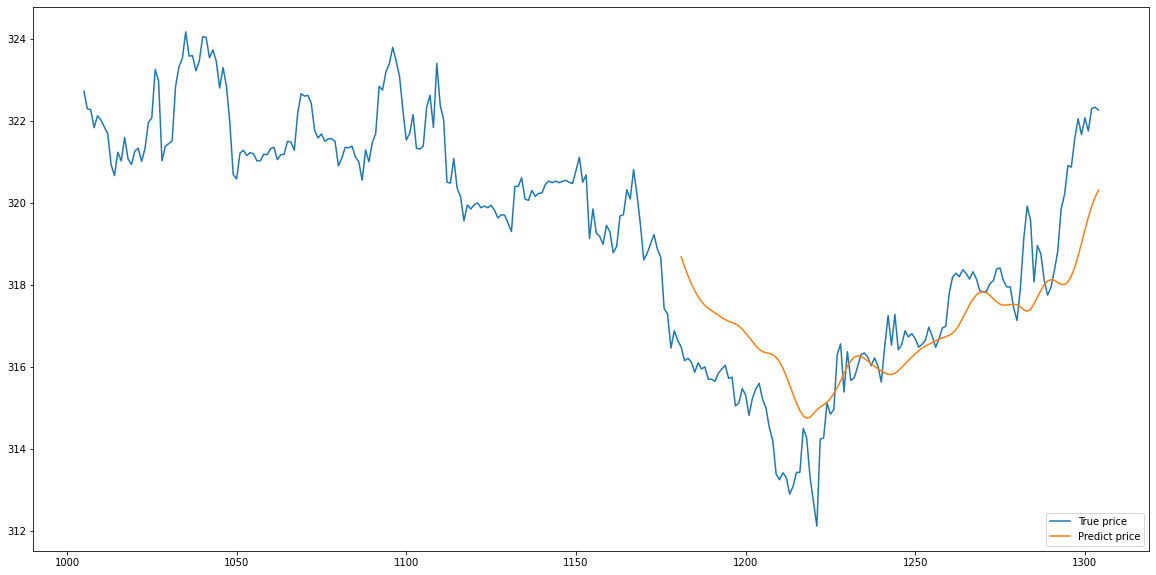

In [75]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

Epoch 1/25
32/32 [==============================] - 17s 173ms/step - loss: 0.0261 - val_loss: 0.0011
Epoch 2/25
32/32 [==============================] - 3s 97ms/step - loss: 0.0071 - val_loss: 8.3858e-04
Epoch 3/25
32/32 [==============================] - 3s 95ms/step - loss: 0.0055 - val_loss: 7.7570e-04
Epoch 4/25
32/32 [==============================] - 3s 96ms/step - loss: 0.0053 - val_loss: 8.6447e-04
Epoch 5/25
32/32 [==============================] - 3s 102ms/step - loss: 0.0046 - val_loss: 9.8473e-04
Epoch 6/25
32/32 [==============================] - 3s 97ms/step - loss: 0.0051 - val_loss: 0.0010
Epoch 7/25
32/32 [==============================] - 3s 95ms/step - loss: 0.0047 - val_loss: 6.9334e-04
Epoch 8/25
32/32 [==============================] - 3s 95ms/step - loss: 0.0039 - val_loss: 7.1211e-04
Epoch 9/25
32/32 [==============================] - 3s 103ms/step - loss: 0.0046 - val_loss: 7.0525e-04
Epoch 10/25
32/32 [==============================] - 3s 94ms/step - loss: 0.0

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


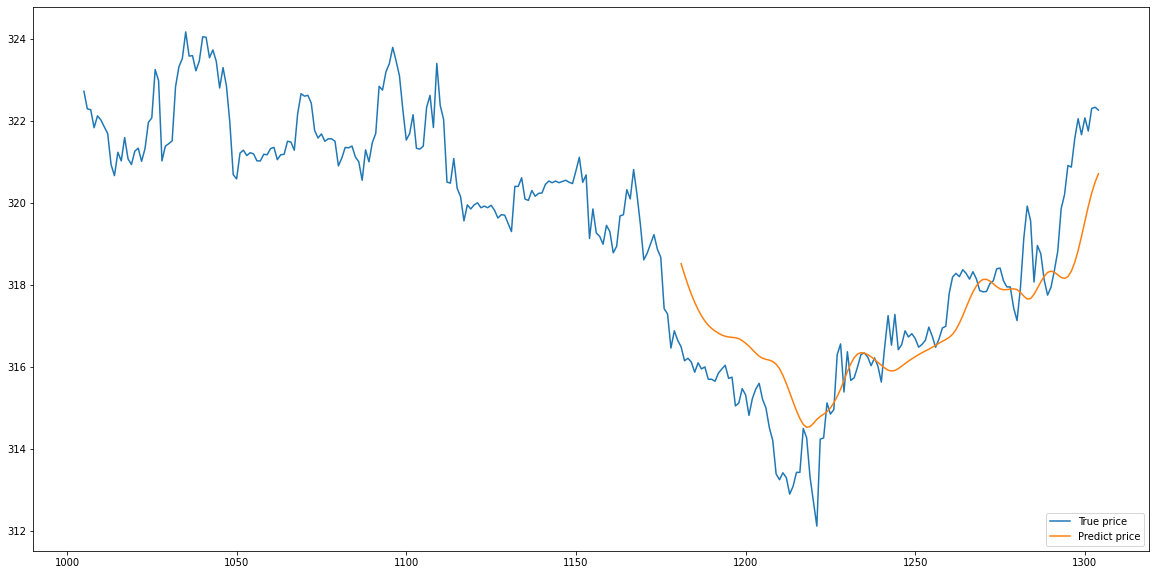

In [76]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

Epoch 1/25
32/32 [==============================] - 18s 174ms/step - loss: 0.0278 - val_loss: 0.0042
Epoch 2/25
32/32 [==============================] - 3s 96ms/step - loss: 0.0089 - val_loss: 0.0014
Epoch 3/25
32/32 [==============================] - 3s 91ms/step - loss: 0.0059 - val_loss: 0.0049
Epoch 4/25
32/32 [==============================] - 3s 89ms/step - loss: 0.0064 - val_loss: 0.0011
Epoch 5/25
32/32 [==============================] - 3s 98ms/step - loss: 0.0047 - val_loss: 6.8664e-04
Epoch 6/25
32/32 [==============================] - 3s 91ms/step - loss: 0.0045 - val_loss: 0.0013
Epoch 7/25
32/32 [==============================] - 3s 90ms/step - loss: 0.0046 - val_loss: 8.8980e-04
Epoch 8/25
32/32 [==============================] - 3s 92ms/step - loss: 0.0038 - val_loss: 8.1114e-04
Epoch 9/25
32/32 [==============================] - 3s 99ms/step - loss: 0.0045 - val_loss: 8.4398e-04
Epoch 10/25
32/32 [==============================] - 3s 90ms/step - loss: 0.0037 - val_loss

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


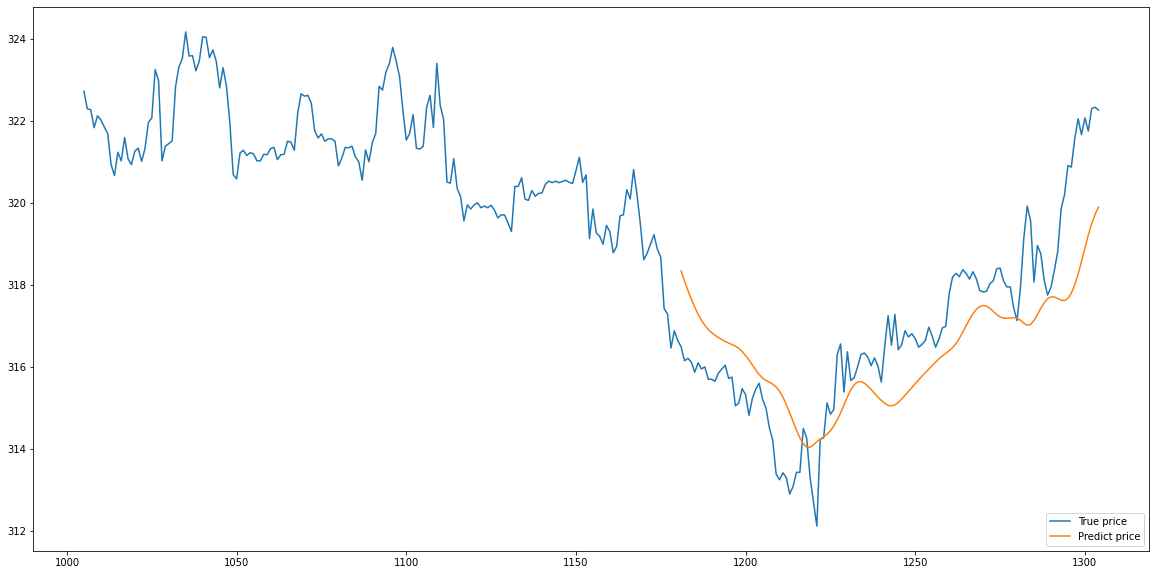

In [77]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']].values

scaler = MinMaxScaler(feature_range=(0,1))
dataset = scaler.fit_transform(dataset)

X, y = [], []
for i in range(60, len(dataset)):
    X.append(dataset[i-60:i][:])
    y.append(dataset[i][0])

X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], dataset.shape[1])))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=25, batch_size=32, shuffle=True, validation_data=(X_val, y_val))
model.save("./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5")

model_rnn = load_model('./MODEL/RNN_BBANDS_ROC_RSI_SMA.h5')

predictions = model_rnn.predict(X_test)
predictions = scaler.inverse_transform(np.tile(predictions, (1, dataset.shape[1])))[:, 0]

prediction_df = original_df.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

## 3. XGBOOST

### a. Prepare Input

In [78]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume']]
dataset

close     volume
0     345.048    22743.0
1     345.142   100242.0
2     343.999  2427950.0
3     342.856  1610635.0
4     344.194  1093191.0
...       ...        ...
1300  322.070   590098.0
1301  321.750   336576.0
1302  322.300   362083.0
1303  322.330   377732.0
1304  322.260   495430.0

[1305 rows x 2 columns]

In [79]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
dataset

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume  close_date_1  volume_date_1  close_date_2  \
0     345.048    22743.0           NaN            NaN           NaN   
1     345.142   100242.0       345.048        22743.0           NaN   
2     343.999  2427950.0       345.142       100242.0       345.048   
3     342.856  1610635.0       343.999      2427950.0       345.142   
4     344.194  1093191.0       342.856      1610635.0       343.999   
...       ...        ...           ...            ...           ...   
1300  322.070   590098.0       321.660       514458.0       322.050   
1301  321.750   336576.0       322.070       590098.0       321.660   
1302  322.300   362083.0       321.750       336576.0       322.070   
1303  322.330   377732.0       322.300       362083.0       321.750   
1304  322.260   495430.0       322.330       377732.0       322.300   

      volume_date_2  
0               NaN  
1               NaN  
2           22743.0  
3          100242.0  
4         2427950.0  
...             ...  
1300       332251.0  
1301       514458.0  
1302       590098.0  
1303       336576.0  
1304       362083.0  

[1305 rows x 6 columns]

In [80]:
dataset.dropna(inplace=True)
dataset

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


close     volume  close_date_1  volume_date_1  close_date_2  \
2     343.999  2427950.0       345.142       100242.0       345.048   
3     342.856  1610635.0       343.999      2427950.0       345.142   
4     344.194  1093191.0       342.856      1610635.0       343.999   
5     345.073   988857.0       344.194      1093191.0       342.856   
6     344.034   976103.0       345.073       988857.0       344.194   
...       ...        ...           ...            ...           ...   
1300  322.070   590098.0       321.660       514458.0       322.050   
1301  321.750   336576.0       322.070       590098.0       321.660   
1302  322.300   362083.0       321.750       336576.0       322.070   
1303  322.330   377732.0       322.300       362083.0       321.750   
1304  322.260   495430.0       322.330       377732.0       322.300   

      volume_date_2  
2           22743.0  
3          100242.0  
4         2427950.0  
5         1610635.0  
6         1093191.0  
...             ...  
1300       332251.0  
1301       514458.0  
1302       590098.0  
1303       336576.0  
1304       362083.0  

[1303 rows x 6 columns]

In [81]:
X = dataset.drop(['close', 'volume'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1303, 4)
(1303, 1)


close_date_1  volume_date_1  close_date_2  volume_date_2
2          345.142       100242.0       345.048        22743.0
3          343.999      2427950.0       345.142       100242.0
4          342.856      1610635.0       343.999      2427950.0
5          344.194      1093191.0       342.856      1610635.0
6          345.073       988857.0       344.194      1093191.0
...            ...            ...           ...            ...
1300       321.660       514458.0       322.050       332251.0
1301       322.070       590098.0       321.660       514458.0
1302       321.750       336576.0       322.070       590098.0
1303       322.300       362083.0       321.750       336576.0
1304       322.330       377732.0       322.300       362083.0

[1303 rows x 4 columns]

In [82]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1173, 4)
Size test:  (130, 4)


### b. Train Model

In [83]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST.dat", "wb"))

### c. Test Model

In [84]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST.dat", "rb"))

In [85]:
predictions = model_xgboost.predict(X_test)
predictions

array([319.572  , 319.17908, 319.6376 , 319.58435, 319.65607, 319.6818 ,
       319.55984, 319.60577, 319.86374, 319.84323, 319.4263 , 319.72226,
       319.6017 , 319.78445, 319.6789 , 319.8513 , 319.8482 , 319.71988,
       319.767  , 319.73367, 319.7954 , 319.78683, 319.7422 , 319.56635,
       319.6662 , 319.7487 , 319.77664, 319.8104 , 319.6755 , 319.7487 ,
       319.79764, 319.79645, 319.79532, 319.84644, 319.75986, 319.84344,
       319.59512, 319.74402, 319.68036, 319.61102, 319.59512, 319.73926,
       319.60626, 319.571  , 319.17795, 319.48596, 319.9187 , 319.42053,
       319.6072 , 319.5885 , 319.32446, 319.87363, 319.4684 , 319.38455,
       319.4646 , 319.62302, 319.78802, 319.5096 , 319.44183, 319.56686,
       319.84555, 319.45547, 319.5244 , 319.44562, 319.7328 , 319.39902,
       319.62082, 319.3412 , 319.34207, 319.41864, 319.47708, 319.59985,
       319.51578, 319.41092, 319.44113, 319.42828, 319.78375, 319.78375,
       319.68597, 319.82538, 319.77664, 319.79532, 

In [86]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume  close_date_1  volume_date_1  close_date_2  \
1175  318.672   536024.0       318.870       383299.0       319.225   
1176  317.420   732425.0       318.672       536024.0       318.870   
1177  317.290   965955.0       317.420       732425.0       318.672   
1178  316.460   958575.0       317.290       965955.0       317.420   
1179  316.880  1854357.0       316.460       958575.0       317.290   
...       ...        ...           ...            ...           ...   
1300  322.070   590098.0       321.660       514458.0       322.050   
1301  321.750   336576.0       322.070       590098.0       321.660   
1302  322.300   362083.0       321.750       336576.0       322.070   
1303  322.330   377732.0       322.300       362083.0       321.750   
1304  322.260   495430.0       322.330       377732.0       322.300   

      volume_date_2  predictions  
1175       414513.0   319.571991  
1176       383299.0   319.179077  
1177       536024.0   319.637604  
1178       732425.0   319.584351  
1179       965955.0   319.656067  
...             ...          ...  
1300       332251.0   322.077087  
1301       514458.0   321.911774  
1302       590098.0   321.709808  
1303       336576.0   322.407654  
1304       362083.0   322.239288  

[130 rows x 7 columns]

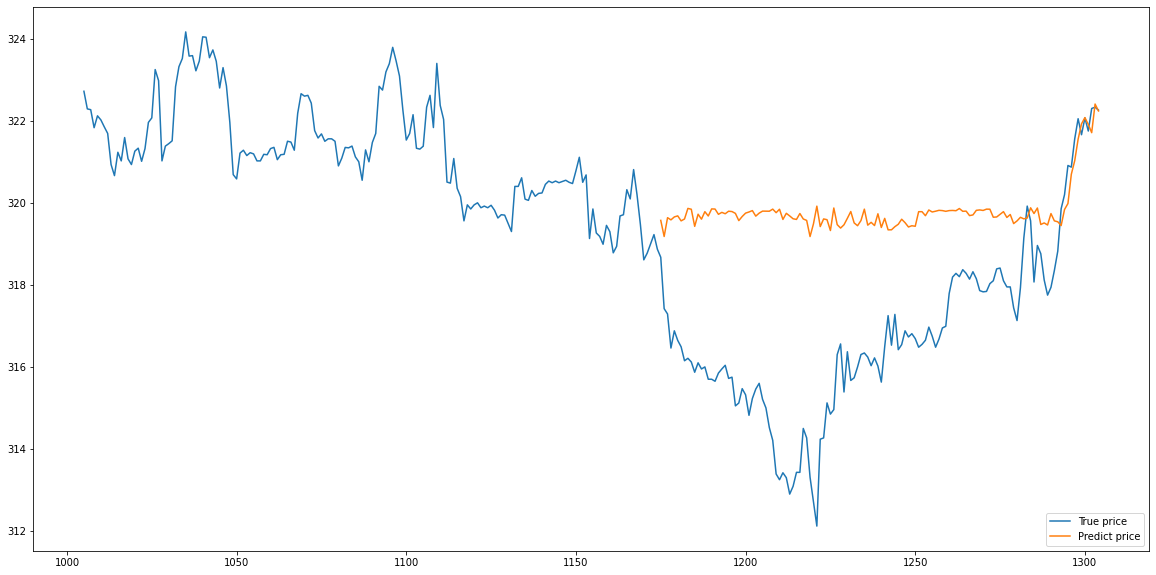

In [87]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### d. Combine Indicators

#### + ROC

In [88]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC']]
dataset

close     volume     ROC
0     345.048    22743.0 -0.3094
1     345.142   100242.0 -0.0258
2     343.999  2427950.0 -0.3196
3     342.856  1610635.0 -0.6422
4     344.194  1093191.0 -0.3062
...       ...        ...     ...
1300  322.070   590098.0  1.5577
1301  321.750   336576.0  1.2015
1302  322.300   362083.0  0.9898
1303  322.330   377732.0  0.7533
1304  322.260   495430.0  0.8449

[1305 rows x 3 columns]

In [89]:
for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
dataset

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
0     345.048    22743.0 -0.3094           NaN            NaN         NaN   
1     345.142   100242.0 -0.0258       345.048        22743.0     -0.3094   
2     343.999  2427950.0 -0.3196       345.142       100242.0     -0.0258   
3     342.856  1610635.0 -0.6422       343.999      2427950.0     -0.3196   
4     344.194  1093191.0 -0.3062       342.856      1610635.0     -0.6422   
...       ...        ...     ...           ...            ...         ...   
1300  322.070   590098.0  1.5577       321.660       514458.0      1.3294   
1301  321.750   336576.0  1.2015       322.070       590098.0      1.5577   
1302  322.300   362083.0  0.9898       321.750       336576.0      1.2015   
1303  322.330   377732.0  0.7533       322.300       362083.0      0.9898   
1304  322.260   495430.0  0.8449       322.330       377732.0      0.7533   

      close_date_2  volume_date_2  ROC_date_2  
0              NaN            NaN         NaN  
1              NaN            NaN         NaN  
2          345.048        22743.0     -0.3094  
3          345.142       100242.0     -0.0258  
4          343.999      2427950.0     -0.3196  
...            ...            ...         ...  
1300       322.050       332251.0      1.2895  
1301       321.660       514458.0      1.3294  
1302       322.070       590098.0      1.5577  
1303       321.750       336576.0      1.2015  
1304       322.300       362083.0      0.9898  

[1305 rows x 9 columns]

In [90]:
dataset.dropna(inplace=True)
dataset

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
2     343.999  2427950.0 -0.3196       345.142       100242.0     -0.0258   
3     342.856  1610635.0 -0.6422       343.999      2427950.0     -0.3196   
4     344.194  1093191.0 -0.3062       342.856      1610635.0     -0.6422   
5     345.073   988857.0 -0.1152       344.194      1093191.0     -0.3062   
6     344.034   976103.0 -0.4015       345.073       988857.0     -0.1152   
...       ...        ...     ...           ...            ...         ...   
1300  322.070   590098.0  1.5577       321.660       514458.0      1.3294   
1301  321.750   336576.0  1.2015       322.070       590098.0      1.5577   
1302  322.300   362083.0  0.9898       321.750       336576.0      1.2015   
1303  322.330   377732.0  0.7533       322.300       362083.0      0.9898   
1304  322.260   495430.0  0.8449       322.330       377732.0      0.7533   

      close_date_2  volume_date_2  ROC_date_2  
2          345.048        22743.0     -0.3094  
3          345.142       100242.0     -0.0258  
4          343.999      2427950.0     -0.3196  
5          342.856      1610635.0     -0.6422  
6          344.194      1093191.0     -0.3062  
...            ...            ...         ...  
1300       322.050       332251.0      1.2895  
1301       321.660       514458.0      1.3294  
1302       322.070       590098.0      1.5577  
1303       321.750       336576.0      1.2015  
1304       322.300       362083.0      0.9898  

[1303 rows x 9 columns]

In [91]:
X = dataset.drop(['close', 'volume', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])
print(X.shape)
print(y.shape)
X

(1303, 6)
(1303, 1)


close_date_1  volume_date_1  ROC_date_1  close_date_2  volume_date_2  \
2          345.142       100242.0     -0.0258       345.048        22743.0   
3          343.999      2427950.0     -0.3196       345.142       100242.0   
4          342.856      1610635.0     -0.6422       343.999      2427950.0   
5          344.194      1093191.0     -0.3062       342.856      1610635.0   
6          345.073       988857.0     -0.1152       344.194      1093191.0   
...            ...            ...         ...           ...            ...   
1300       321.660       514458.0      1.3294       322.050       332251.0   
1301       322.070       590098.0      1.5577       321.660       514458.0   
1302       321.750       336576.0      1.2015       322.070       590098.0   
1303       322.300       362083.0      0.9898       321.750       336576.0   
1304       322.330       377732.0      0.7533       322.300       362083.0   

      ROC_date_2  
2        -0.3094  
3        -0.0258  
4        -0.3196  
5        -0.6422  
6        -0.3062  
...          ...  
1300      1.2895  
1301      1.3294  
1302      1.5577  
1303      1.2015  
1304      0.9898  

[1303 rows x 6 columns]

In [92]:
X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]
print("Size train: ", X_train.shape)
print("Size test: ", X_test.shape)

Size train:  (1173, 6)
Size test:  (130, 6)


In [93]:
xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC.dat", "wb"))

In [94]:
model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC.dat", "rb"))

In [95]:
predictions = model_xgboost.predict(X_test)
predictions

array([319.77753, 319.55237, 319.3548 , 319.8433 , 319.8329 , 319.98795,
       319.6932 , 319.61887, 319.77628, 319.98544, 319.8712 , 319.79288,
       319.883  , 319.9812 , 319.92285, 319.83884, 319.75922, 319.77542,
       319.8115 , 319.9013 , 319.6766 , 319.8129 , 319.71985, 319.48077,
       319.75986, 319.75153, 319.7421 , 319.5207 , 319.87567, 319.75638,
       319.55676, 319.68338, 319.7976 , 319.82492, 319.45154, 319.7403 ,
       319.6627 , 319.63843, 319.60904, 319.76447, 319.78366, 319.6629 ,
       319.57892, 319.65463, 319.57443, 319.6133 , 319.95963, 319.88712,
       319.73926, 319.66394, 319.61298, 319.83093, 319.5696 , 319.6668 ,
       319.64343, 319.71738, 319.86404, 319.50055, 319.51062, 319.6699 ,
       319.8411 , 319.59866, 319.52908, 319.4151 , 320.1037 , 319.5831 ,
       319.80765, 319.67377, 319.6108 , 319.5595 , 319.62177, 319.40173,
       319.85437, 319.82477, 319.82596, 319.6023 , 319.76547, 319.7059 ,
       319.70276, 319.85883, 319.83548, 319.828  , 

In [96]:
prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions
prediction_df

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)


close     volume     ROC  close_date_1  volume_date_1  ROC_date_1  \
1175  318.672   536024.0 -0.3683       318.870       383299.0     -0.0815   
1176  317.420   732425.0 -0.5779       318.672       536024.0     -0.3683   
1177  317.290   965955.0 -0.5928       317.420       732425.0     -0.5779   
1178  316.460   958575.0 -0.7931       317.290       965955.0     -0.5928   
1179  316.880  1854357.0 -0.8045       316.460       958575.0     -0.7931   
...       ...        ...     ...           ...            ...         ...   
1300  322.070   590098.0  1.5577       321.660       514458.0      1.3294   
1301  321.750   336576.0  1.2015       322.070       590098.0      1.5577   
1302  322.300   362083.0  0.9898       321.750       336576.0      1.2015   
1303  322.330   377732.0  0.7533       322.300       362083.0      0.9898   
1304  322.260   495430.0  0.8449       322.330       377732.0      0.7533   

      close_date_2  volume_date_2  ROC_date_2  predictions  
1175       319.225       414513.0     -0.4537   319.777527  
1176       318.870       383299.0     -0.0815   319.552368  
1177       318.672       536024.0     -0.3683   319.354797  
1178       317.420       732425.0     -0.5779   319.843292  
1179       317.290       965955.0     -0.5928   319.832886  
...            ...            ...         ...          ...  
1300       322.050       332251.0      1.2895   321.807404  
1301       321.660       514458.0      1.3294   321.889618  
1302       322.070       590098.0      1.5577   321.557739  
1303       321.750       336576.0      1.2015   322.278473  
1304       322.300       362083.0      0.9898   322.025146  

[130 rows x 10 columns]

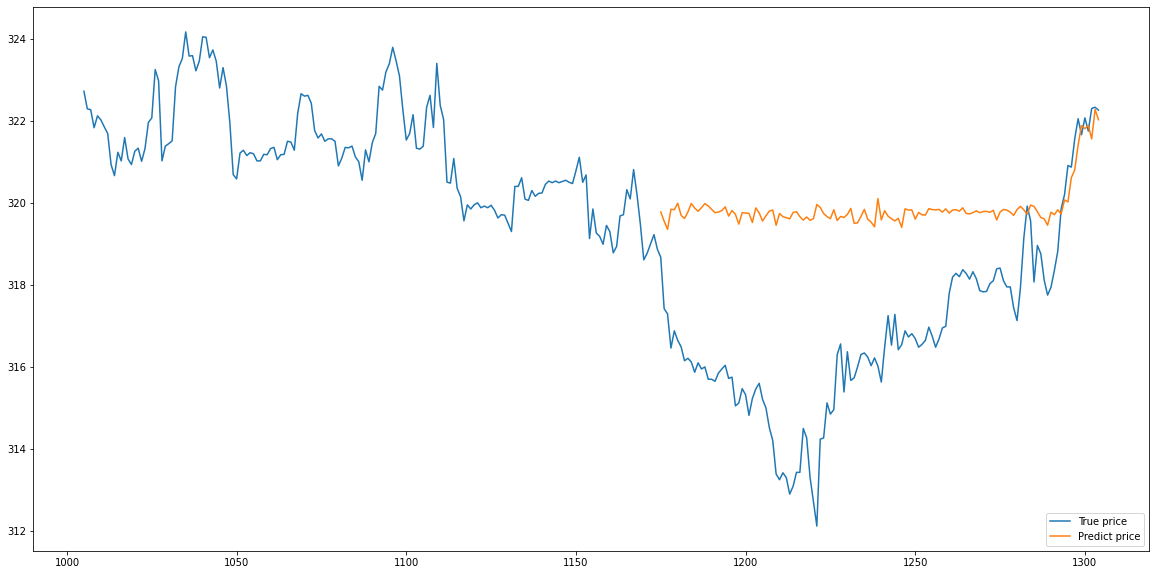

In [97]:
plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + SMA

/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/core/frame.py:3607: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._set_item(key, value)
/Users/lucky/PycharmProjects/stock-prediction-project/venv/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


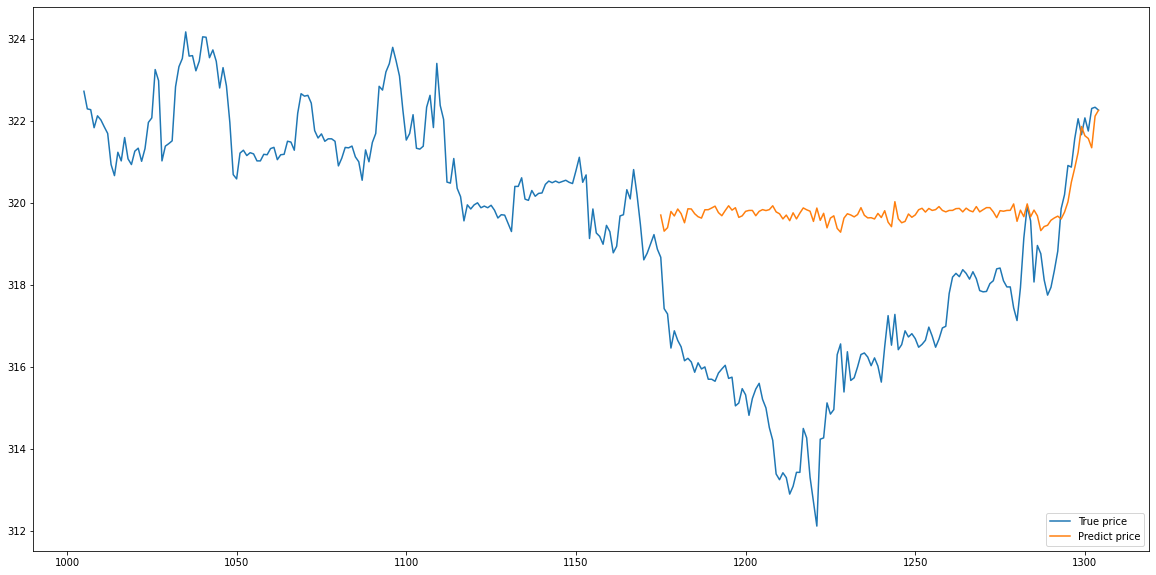

In [98]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI

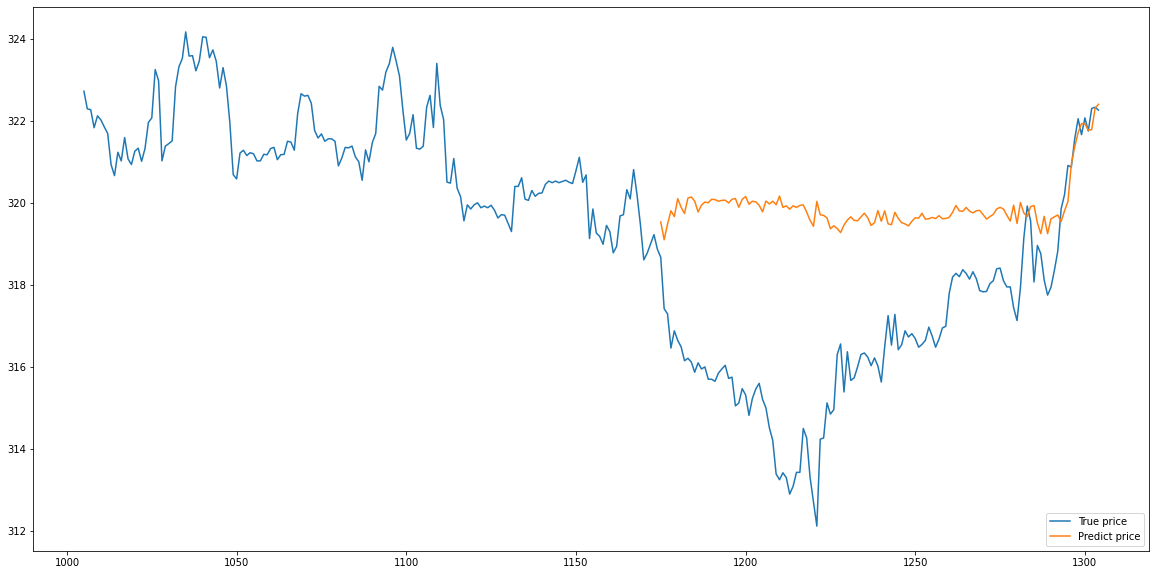

In [99]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS

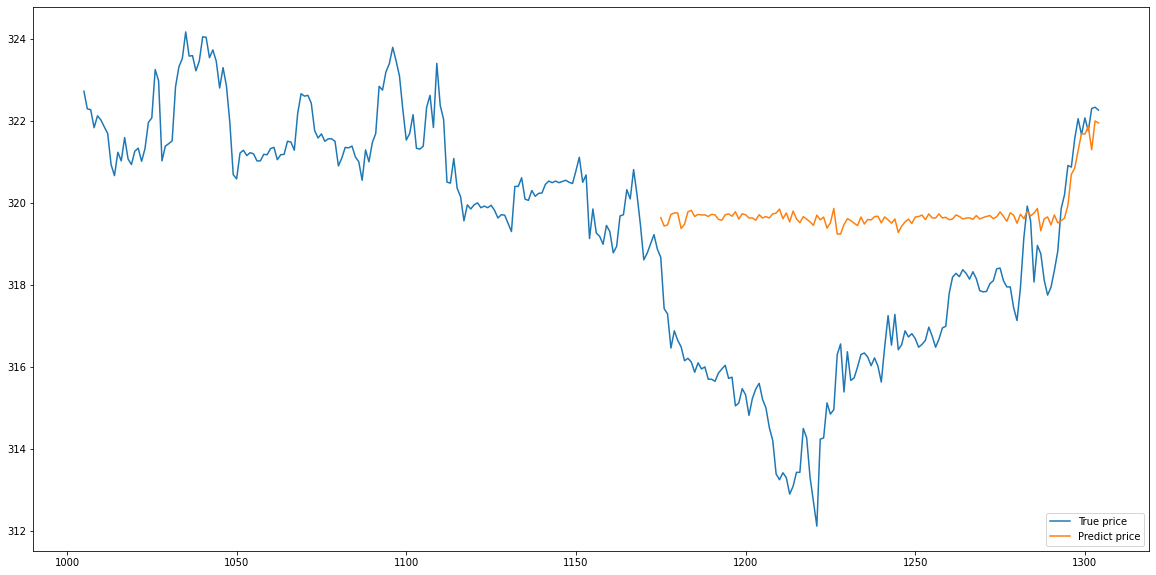

In [100]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)


dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC

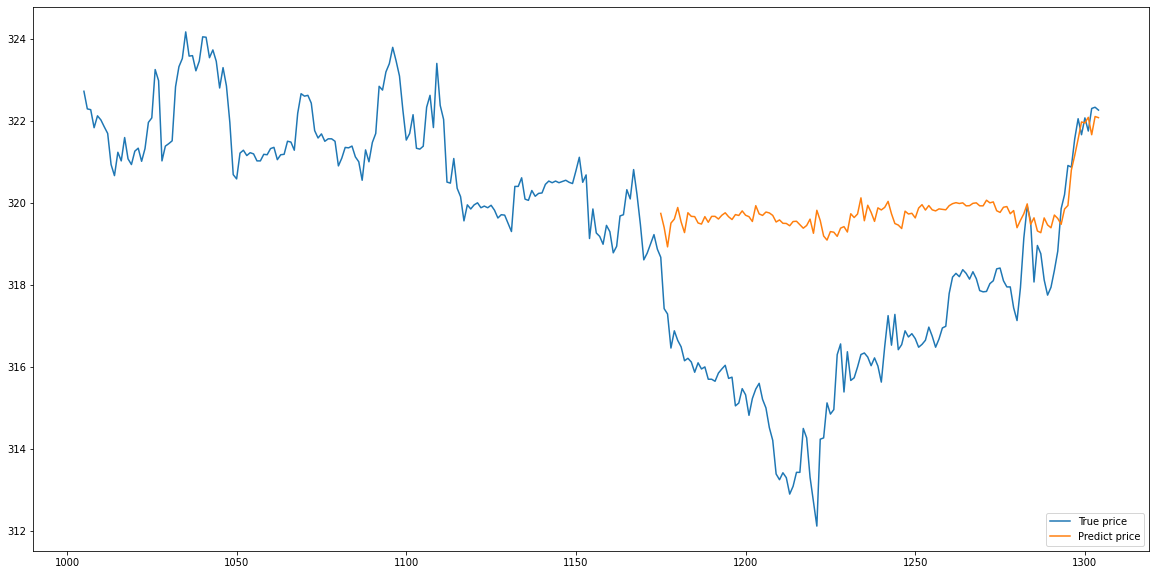

In [101]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI

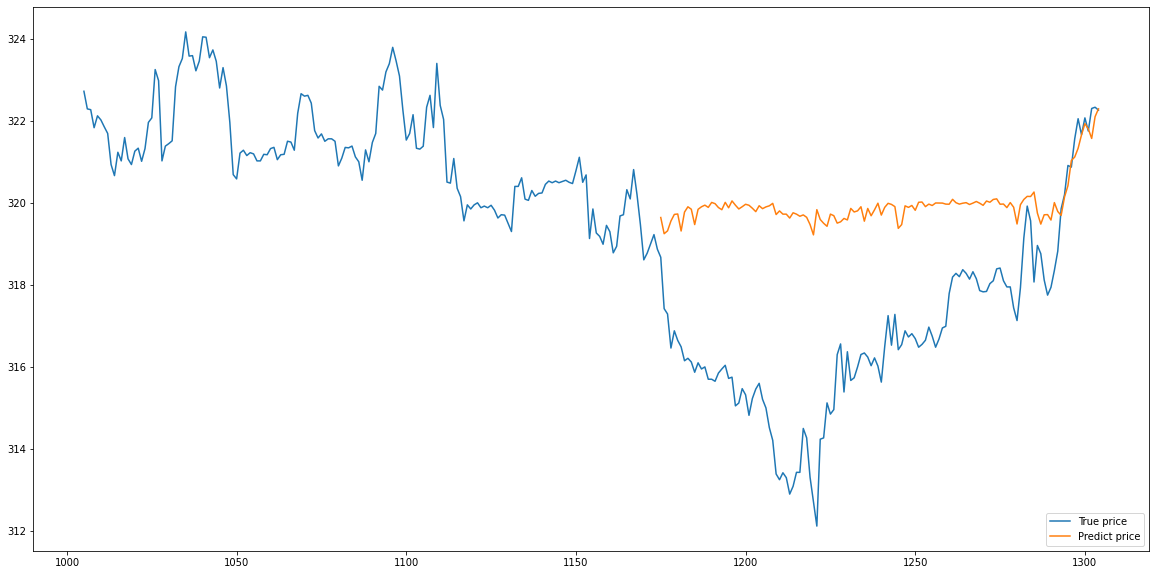

In [102]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + SMA

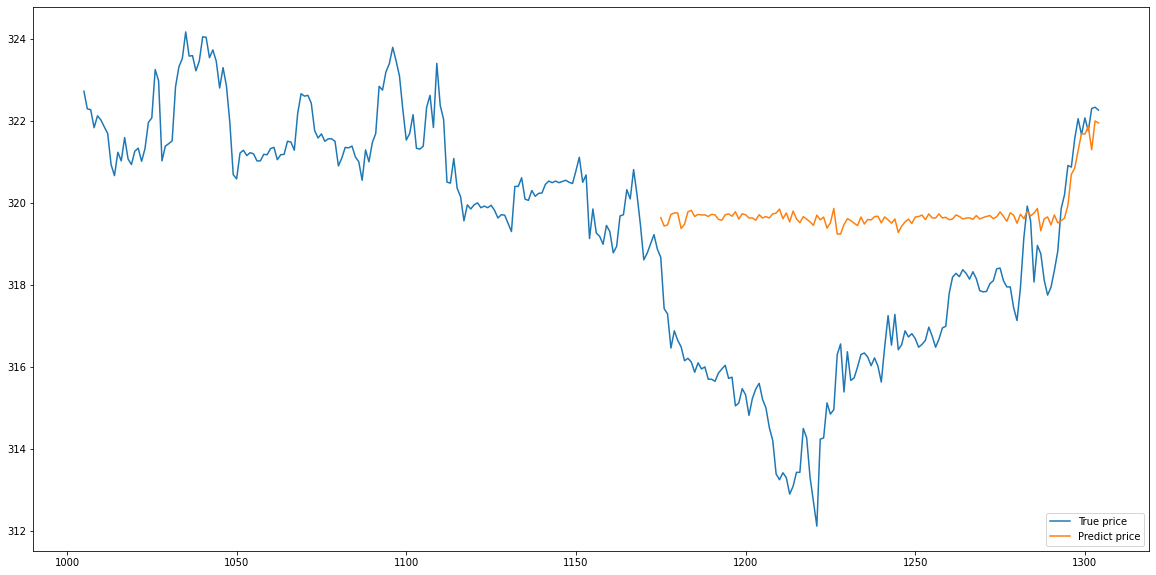

In [103]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI

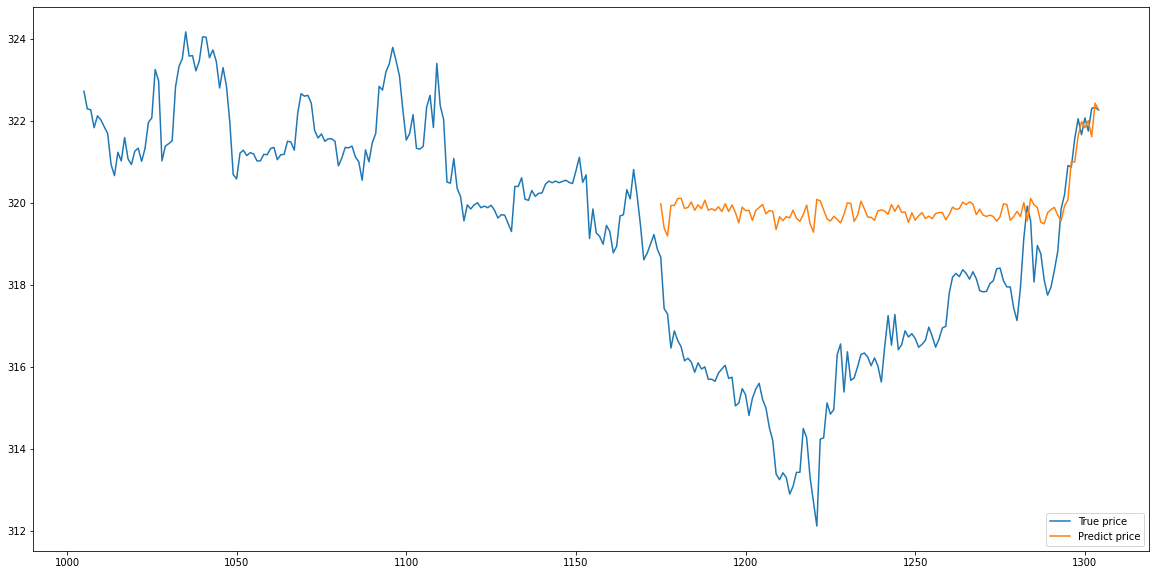

In [104]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + SMA

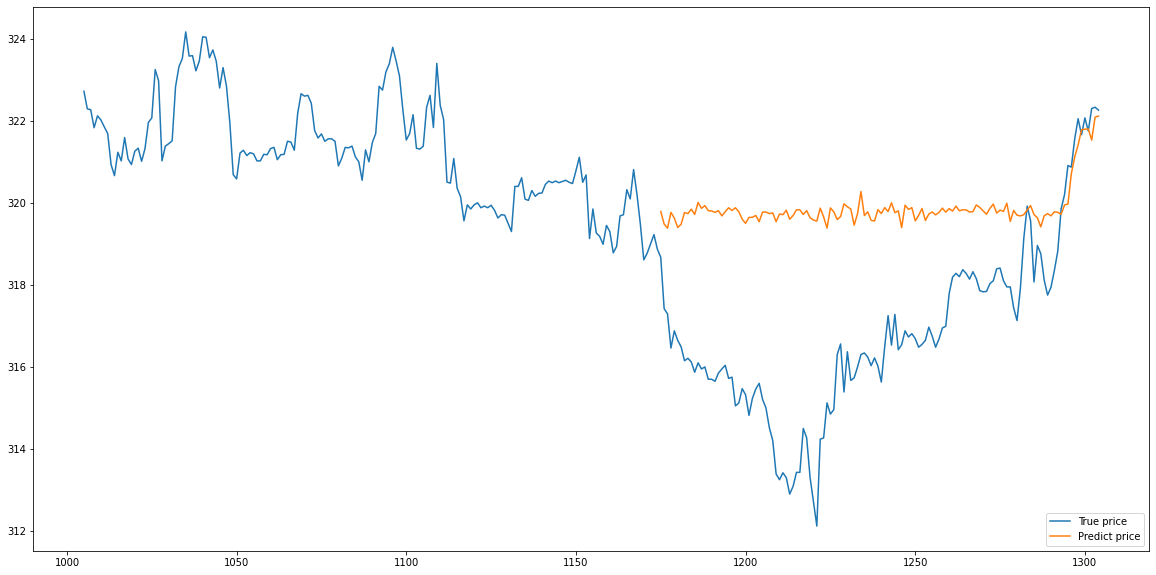

In [105]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + RSI + SMA

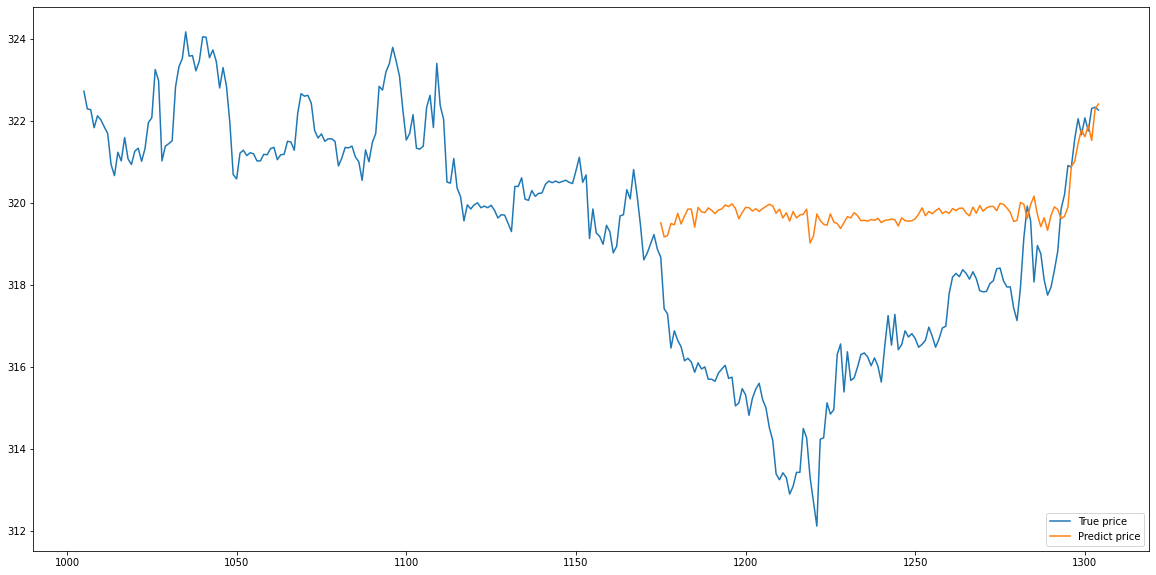

In [106]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI

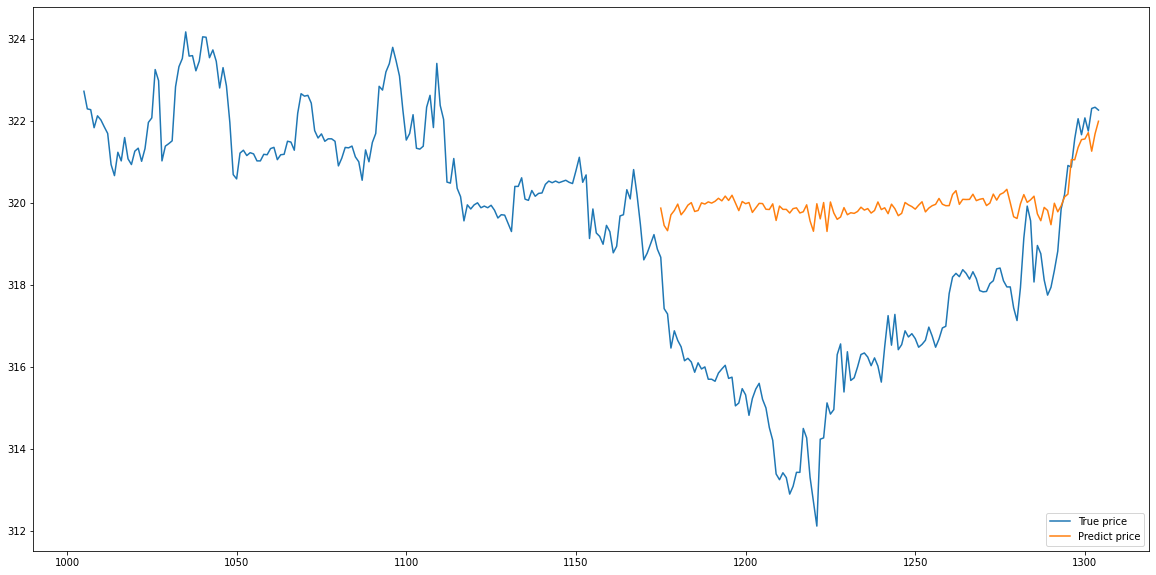

In [107]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

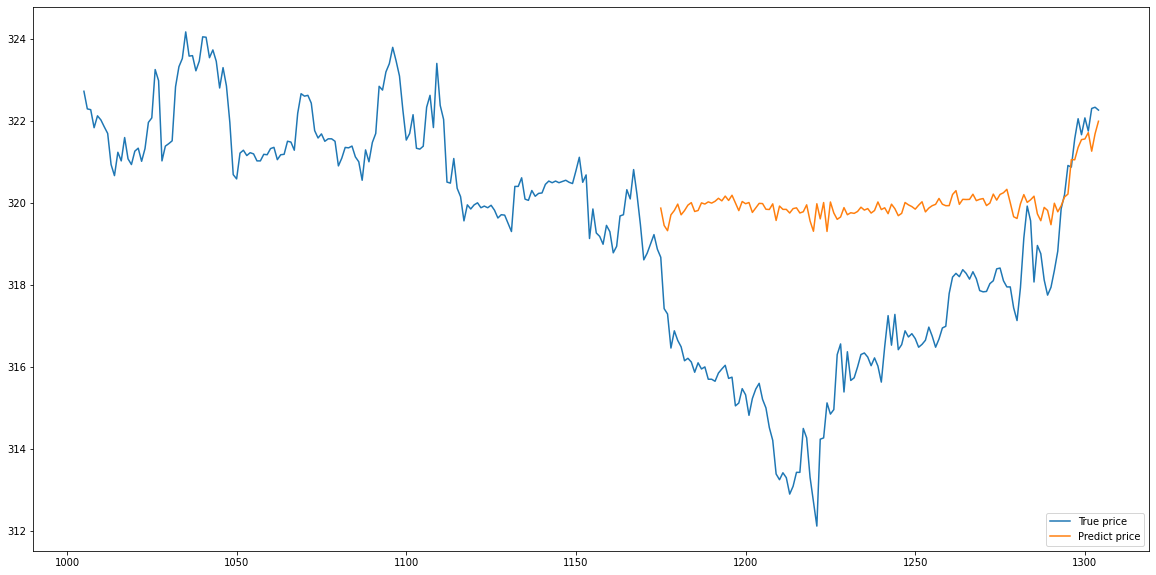

In [108]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + SMA

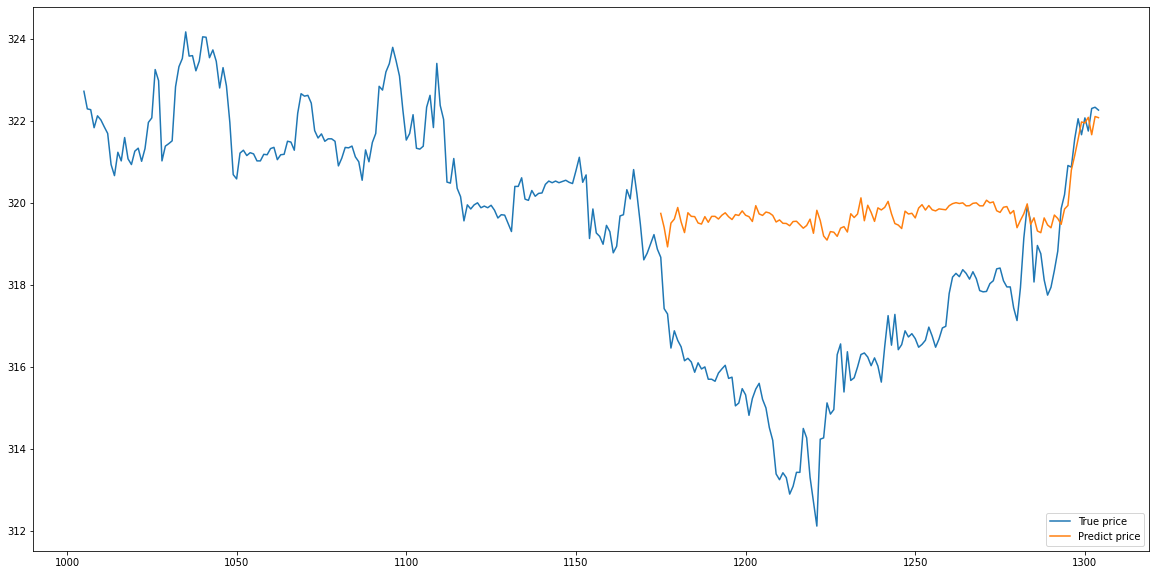

In [109]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + RSI + SMA

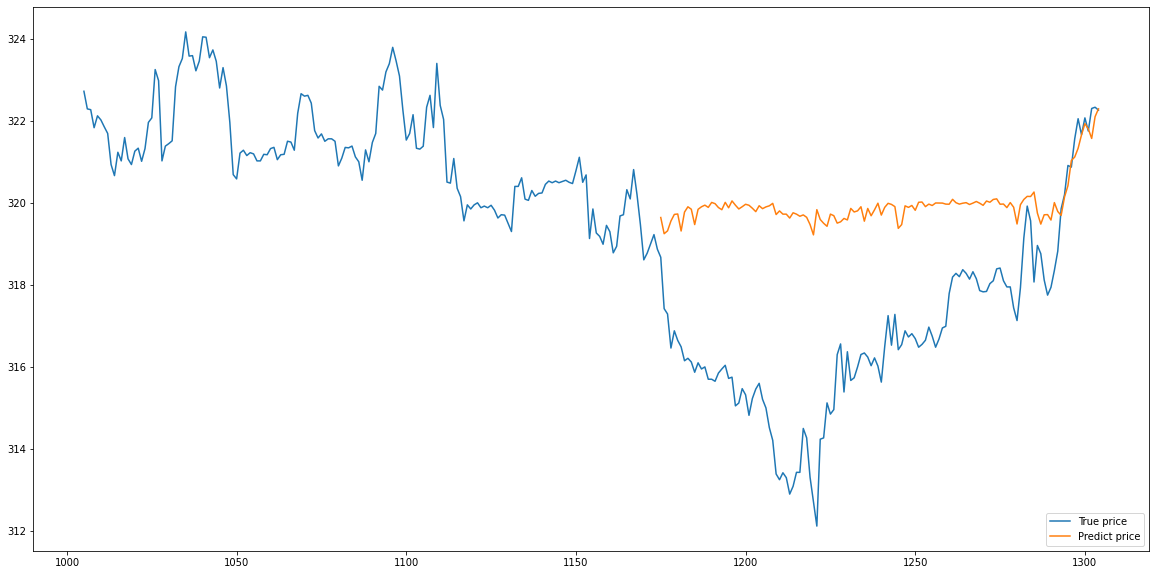

In [110]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + ROC + RSI + SMA

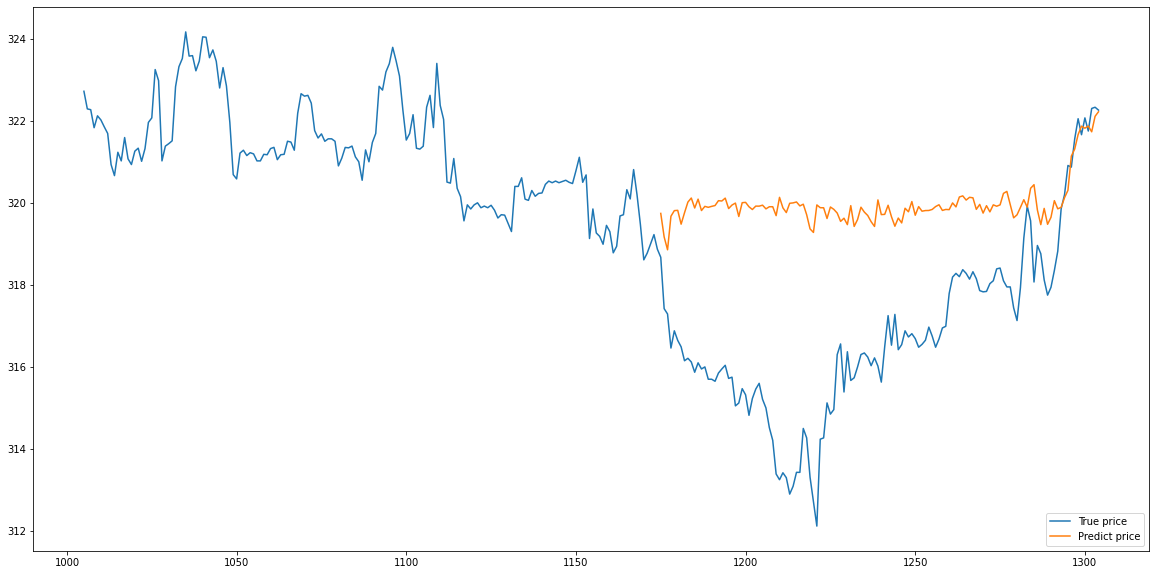

In [111]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["SMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

#### + BBANDS + ROC + RSI + SMA

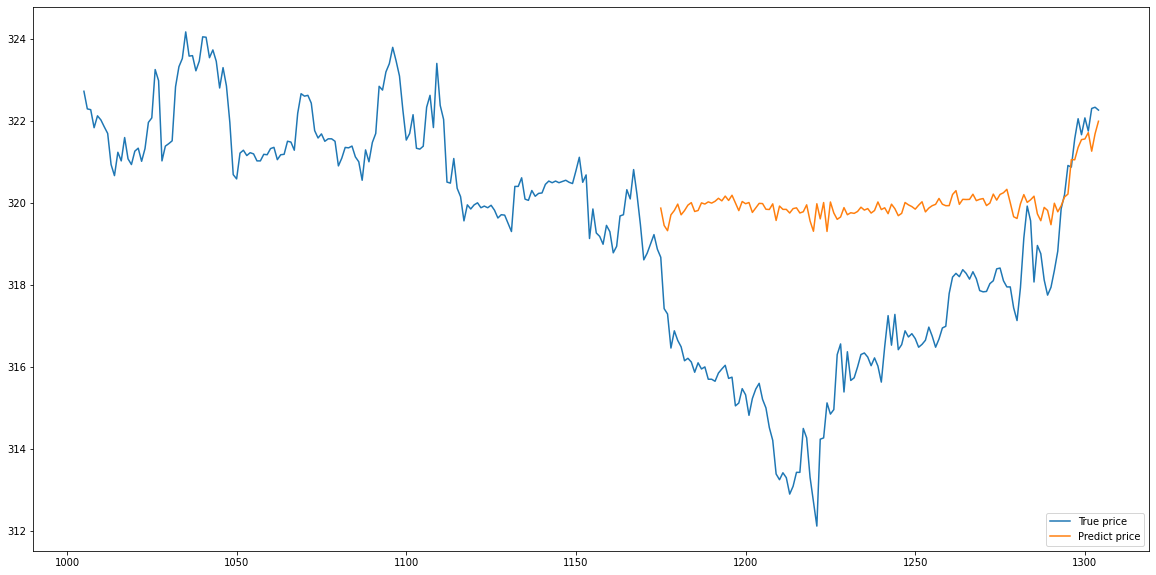

In [112]:
original_df = pd.read_csv("./DATA/MSFT.csv")
dataset = original_df
dataset = dataset[['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA']]

for i in range (1, 3):
    dataset["close_date_" + str(i)] = dataset.close.shift(i)
    dataset["volume_date_" + str(i)] = dataset.volume.shift(i)
    dataset["RLB_date_" + str(i)] = dataset['Real Lower Band'].shift(i)
    dataset["RMB_date_" + str(i)] = dataset['Real Middle Band'].shift(i)
    dataset["RUB_date_" + str(i)] = dataset['Real Upper Band'].shift(i)
    dataset["ROC_date_" + str(i)] = dataset.ROC.shift(i)
    dataset["RSI_date_" + str(i)] = dataset.RSI.shift(i)
    dataset["RMA_date_" + str(i)] = dataset.SMA.shift(i)

dataset.dropna(inplace=True)

X = dataset.drop(['close', 'volume', 'Real Lower Band', 'Real Middle Band', 'Real Upper Band', 'ROC', 'RSI', 'SMA'], axis=1)
y = pd.DataFrame(dataset['close'])

X_train, y_train = X[:math.ceil(len(X)*0.9)], y[:math.ceil(len(X)*0.9)]
X_test, y_test = X[math.ceil(len(X)*0.9):], y[math.ceil(len(X)*0.9):]

xgb = xgboost.XGBRegressor(n_estimators=100, 
                           max_depth=8, 
                           learning_rate=0.1,
                           min_child_weight=5,
                           subsample=0.1, 
                           colsample_bytree=1, 
                           colsample_bylevel=1,
                           gamma=0.3,
                           objective='reg:squarederror')
model = xgb.fit(X_train, y_train)
pickle.dump(model, open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "wb"))

model_xgboost = pickle.load(open("./MODEL/XGBOOST_BBANDS_ROC_RSI_SMA.dat", "rb"))

predictions = model_xgboost.predict(X_test)

prediction_df = dataset.iloc[-len(predictions):]
prediction_df['predictions'] = predictions

plt.figure(figsize = (20, 10))
plt.plot(original_df['close'][-300:])
plt.plot(prediction_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

### Predict Future

In [113]:
def xgboost_predict_future(data, modelName, indicatorArr, period):
    modelFileName = './MODEL/' + modelName
    sorted(indicatorArr)
    for indicator in indicatorArr:
        if indicator == 'close':
            continue
        modelFileName = modelFileName + '_' + indicator
    modelFileName = modelFileName + '.dat'
    model = pickle.load(open(modelFileName, "rb"))
    numDataPoint = int(period / 15)
    
    temp = indicatorArr.copy()
    temp.append('volume')
    data = data[temp]
    data = data[-5:]
    
    X = pd.DataFrame({})
    for column in data.columns:
        n = len(data)
        for i in range(1, n + 1):
            X[column + '_date_' + str(i)] = [data.iloc[n - i][column]] 
    
    predictedValue = model.predict(X)
    
    return predictedValue